In [120]:
# Import packages

import pandas as pd 
import numpy as np 
import os
from bs4 import BeautifulSoup
import time
import requests
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

import pickle
from joblib import dump, load

import warnings

# Set certain settings for the notebook
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

In [99]:
# Check current directory
os.getcwd()

'C:\\Users\\imacd_0odruq3\\Documents\\sports_gambling\\sports_gambling_algorithm'

In [100]:
# Read in data frames

nfl_per_game = pd.read_csv('../data/nfl_per_game_stats.csv')
betting_data = pd.read_csv('../data/betting_data_cleaned.csv')
nfl_elo = pd.read_csv('../data/elo_cleaned.csv')
weather = pd.read_csv('../data/weather.csv')

In [101]:
nfl_per_game

,season,week,team,opponent,score,opponent_score,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,sacks_allowed,fumbles,lost_fumbles,interceptions_thrown,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,avg_cpoe_allowed,sacks,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,passing_epa_def,rushing_epa_def,total_epa,total_opposing_epa
0,2014,1,ARI,LAC,18,17,38,304.0,24.0,6.098425,2.0,3.160065,26,110.0,-7.697317,0.0,7.779734,2.0,2.0,2.0,0.0,24,52.0,-8.805075,1.0,36,238.0,21.0,0.799435,1.0,-6.609174,0.0,0.0,1.0,0.0,-4.751772,-0.799435,8.805075,1.654976,-1.654976
1,2014,1,ATL,NO,37,34,42,448.0,31.0,17.253965,3.0,6.128030,25,123.0,2.559394,1.0,17.526014,1.0,1.0,1.0,0.0,28,139.0,4.264254,3.0,42,333.0,29.0,9.202585,1.0,-0.291977,0.0,1.0,1.0,1.0,-1.162613,-9.202585,-4.264254,5.183908,-5.183908
2,2014,1,BAL,CIN,16,23,62,345.0,35.0,-4.871386,1.0,-11.889451,21,94.0,-0.093163,1.0,-3.078329,3.0,1.0,1.0,1.0,24,81.0,-4.888501,0.0,39,303.0,25.0,11.252418,1.0,-2.044220,0.0,0.0,0.0,0.0,-2.107624,-11.252418,4.888501,-13.436091,13.436091
3,2014,1,BUF,CHI,23,20,22,173.0,16.0,0.368607,1.0,11.150598,31,197.0,4.315138,1.0,0.591515,1.0,0.0,0.0,1.0,18,86.0,-0.055888,0.0,49,349.0,34.0,-6.755498,2.0,2.864331,2.0,1.0,2.0,1.0,3.721131,6.755498,0.055888,15.216262,-15.216262
4,2014,1,CAR,TB,20,14,33,230.0,24.0,8.423189,2.0,9.822589,33,113.0,-6.247634,0.0,10.352312,1.0,1.0,0.0,0.0,17,102.0,1.025410,0.0,35,183.0,22.0,-10.437735,2.0,0.519191,3.0,2.0,2.0,1.0,-3.457676,10.437735,-1.025410,8.130204,-8.130204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,2021,21,KC,CIN,24,27,39,275.0,26.0,-6.372242,3.0,0.665231,24,139.0,4.338426,0.0,-5.461161,4.0,2.0,0.0,2.0,27,116.0,1.386047,0.0,39,252.0,23.0,3.913528,2.0,-1.847335,1.0,0.0,1.0,0.0,-2.057830,-3.913528,-1.386047,-9.391220,9.391220
4308,2021,21,LA,SF,20,17,45,337.0,31.0,13.104126,2.0,6.444984,26,76.0,-7.967496,0.0,11.619948,2.0,0.0,0.0,1.0,20,50.0,-9.073356,0.0,29,232.0,16.0,6.194037,2.0,-18.026170,0.0,0.0,1.0,0.0,-0.072526,-6.194037,9.073356,7.943421,-7.943421
4309,2021,21,SF,LA,17,20,29,232.0,16.0,6.194037,2.0,-18.026170,20,50.0,-9.073356,0.0,5.722747,0.0,0.0,0.0,1.0,26,76.0,-7.967496,0.0,45,337.0,31.0,13.104126,2.0,6.444984,2.0,0.0,1.0,0.0,0.072526,-13.104126,7.967496,-7.943421,7.943421
4310,2021,22,CIN,LA,20,23,34,269.0,23.0,-9.384247,2.0,-1.240713,19,80.0,-1.797324,0.0,-7.677874,7.0,0.0,0.0,0.0,22,44.0,-8.289258,0.0,42,283.0,26.0,3.046524,3.0,-2.291202,2.0,0.0,2.0,0.0,1.208638,-3.046524,8.289258,-4.730199,4.730199


In [102]:
betting_data

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Total Score Open,Total Score Close,Home Odds ML Open,Home Odds ML Close,Away Odds ML Open,Away Odds ML Close,Home Line Odds ML Open,Home Line Odds ML Close,Away Line Odds ML Open,Away Line Odds ML Close,Total Score Over ML Open,Total Score Over ML Close,Total Score Under ML Open,Total Score Under ML Close,Total Score,Open Over/Under Result,Closing Over/Under Result,Home Score Actual Line,Away Score Actual Line,Opening Winner,Closing Winner,Opening Winner Specific,Closing Winner Specific,Winner HA,Line Open Cover,Line Close Cover,Line Open Cover HA,Line Close Cover HA,Home ML Bet Return,Away ML Bet Return,Home Spread Bet Return,Away Spread Bet Return,Favorite ML Bet Return,Underdog ML Bet Return,Favorite Spread Bet Return,Underdog Spread Bet Return,implied_prob_home_open,implied_prob_away_open,implied_prob_home_close,implied_prob_away_close,total_implied_prob_open,total_implied_prob_close
0,2022-01-17,Los Angeles Rams,Arizona Cardinals,34,11,False,True,False,-4.5,-3.5,4.5,3.5,50.5,49.0,-200.0,-172.0,170.0,150.0,-111.0,100.0,-111.0,-120.0,-111.0,-111.0,-111.0,-111.0,45,Under,Under,-23,23,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,50.00,-100.0,90.09,-100.00,50.00,-100.0,90.09,-100.00,0.666667,0.370370,0.632353,0.400000,1.037037,1.032353
1,2022-01-16,Kansas City Chiefs,Pittsburgh Steelers,42,21,False,True,False,-13.5,-12.5,13.5,12.5,46.5,47.0,-714.0,-833.0,500.0,550.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,63,Over,Over,-21,21,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,14.01,-100.0,90.09,-100.00,14.01,-100.0,90.09,-100.00,0.877150,0.166667,0.892819,0.153846,1.043817,1.046665
2,2022-01-16,Dallas Cowboys,San Francisco 49ers,17,23,False,True,False,-3.0,-3.5,3.0,3.5,50.5,51.0,-161.0,-185.0,140.0,165.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,40,Under,Under,6,-6,Underdog,Underdog,Away Underdog,Away Underdog,Away,Underdog,Underdog,Away,Away,-100.00,140.0,-100.00,90.09,-100.00,140.0,-100.00,90.09,0.616858,0.416667,0.649123,0.377358,1.033525,1.026481
3,2022-01-16,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,False,True,False,-8.5,-7.0,8.5,7.0,49.0,47.0,-400.0,-370.0,320.0,280.0,-111.0,-116.0,-111.0,-105.0,-111.0,-111.0,-111.0,-111.0,46,Under,Under,-16,16,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,25.00,-100.0,90.09,-100.00,25.00,-100.0,90.09,-100.00,0.800000,0.238095,0.787234,0.263158,1.038095,1.050392
4,2022-01-15,Buffalo Bills,New England Patriots,47,17,False,True,False,-4.5,-4.5,4.5,4.5,43.5,43.0,-213.0,-222.0,175.0,180.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,64,Over,Over,-30,30,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,46.95,-100.0,90.09,-100.00,46.95,-100.0,90.09,-100.00,0.680511,0.363636,0.689441,0.357143,1.044148,1.046584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,2014-09-07,New York Jets,Las Vegas Raiders,19,14,False,False,False,-5.0,-6.5,5.0,6.5,39.5,41.0,-235.0,-279.0,210.0,246.0,-105.0,-108.0,-105.0,-102.0,-109.0,-105.0,-101.0,-105.0,33,Under,Under,-5,5,Favorite,Favorite,Home Favorite,Home Favorite,Home,Push,Underdog,Push,Away,42.55,-100.0,0.00,0.00,42.55,-100.0,0.00,0.00,0.701493,0.322581,0.736148,0.289017,1.024073,1.025165
2117,2014-09-07,Philadelphia Eagles,Jacksonville Jaguars,34,17,False,False,False,-10.0,-10.0,10.0,10.0,53.0,49.0,-500.0,-515.0,423.0,435.0,-110.0,102.0,100.0,-113.0,-105.0,-110.0,-105.0,100.0,51,Under,Over,-17,17,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,20.00,-100.0,90.91,-100.00,20.00,-100.0,90.91,-100.00,0.833333,0.191205,0.837398,0.186916,1.024538,1.0

In [103]:
nfl_elo

,date,season,home,away,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,quality,importance,total_rating,home_full_name,away_full_name
0,2014-09-04,2014,SEA,GB,1678.971000,1499.827000,0.803040,0.196960,1689.766000,1489.032000,1638.803177,1573.400581,Russell Wilson,Aaron Rodgers,142.614214,171.924074,-2.005879,8.581999,0.661510,0.338490,228.762141,102.577810,151.229006,164.989448,1658.378295,1553.825462,92.0,NaN,NaN,Seattle Seahawks,Green Bay Packers
1,2014-09-07,2014,BAL,CIN,1529.779000,1560.389000,0.549330,0.450670,1506.570000,1583.598000,1516.918641,1540.421039,Joe Flacco,Andy Dalton,80.381110,152.647096,-11.425867,4.817795,0.524369,0.475631,138.967390,260.882901,86.239738,163.470676,1494.941444,1562.398236,61.0,NaN,NaN,Baltimore Ravens,Cincinnati Bengals
2,2014-09-07,2014,ATL,NO,1458.825000,1573.737000,0.428661,0.571339,1475.033000,1557.528000,1495.663302,1576.026869,Matt Ryan,Drew Brees,154.564859,245.800281,-2.544847,12.272470,0.444847,0.555153,475.062354,238.581227,186.614609,245.078376,1511.329440,1560.360730,68.0,NaN,NaN,Atlanta Falcons,New Orleans Saints
3,2014-09-07,2014,DAL,SF,1501.041000,1647.763000,0.384515,0.615485,1482.616000,1666.188000,1498.993694,1616.400037,Tony Romo,Colin Kaepernick,148.268121,169.820983,-1.984593,3.012335,0.412347,0.587653,27.219955,187.738598,136.163304,171.612744,1479.058517,1636.335214,75.0,NaN,NaN,Dallas Cowboys,San Francisco 49ers
4,2014-09-07,2014,MIA,NE,1482.607000,1624.459000,0.391170,0.608830,1515.905000,1591.162000,1490.049731,1606.050490,Ryan Tannehill,Tom Brady,108.401852,169.248661,-1.207283,1.236997,0.416547,0.583453,88.482754,51.729502,106.409942,157.496746,1521.686841,1574.413380,71.0,NaN,NaN,Miami Dolphins,New England Patriots
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,2022-01-17,2021,LAR,ARI,1615.789160,1516.586992,0.720154,0.279846,1632.341105,1500.035047,1597.459409,1514.940528,Matthew Stafford,Kyler Murray,169.067416,222.204809,-6.342367,8.168433,0.702535,0.297465,277.097615,-42.847876,179.870436,195.699541,1615.165080,1497.234857,76.0,100.0,88.0,Los Angeles Rams,Arizona Cardinals
2149,2022-01-22,2021,TEN,CIN,1600.906392,1550.164193,0.660666,0.339334,NaN,NaN,NaN,NaN,Ryan Tannehill,Joe Burrow,156.165151,210.748474,-9.380106,36.274299,0.657162,0.342838,NaN,NaN,NaN,NaN,NaN,NaN,85.0,100.0,93.0,Tennessee Titans,Cincinnati Bengals
2150,2022-01-22,2021,GB,SF,1650.839616,1602.231233,0.657907,0.342093,NaN,NaN,NaN,NaN,Aaron Rodgers,NaN,270.582591,137.485885,22.113780,-1.665996,0.752133,0.247867,NaN,NaN,NaN,NaN,NaN,NaN,97.0,100.0,99.0,Green Bay Packers,San Francisco 49ers
2151,2022-01-23,2021,TB,LAR,1681.797158,1632.341105,0.659005,0.340995,NaN,NaN,NaN,NaN,Tom Brady,Matthew Stafford,249.882409,179.870436,11.456236,-0.623739,0.681440,0.318560,NaN,NaN,NaN,NaN,NaN,NaN,96.0,100.0,98.0,Tampa Bay Buccaneers,Los Angeles Rams


In [104]:
weather

,Unnamed: 0,season,week,home,away,temperature,weather,wind
0,0,2014,1,Seahawks,Packers,70,Fair,5
1,1,2014,2,Ravens,Steelers,80,Mostly Cloudy,0
2,2,2014,3,Falcons,Buccaneers,DOME,DOME,3
3,3,2014,4,Washington,Giants,63,Overcast,7
4,4,2014,5,Packers,Vikings,63,Fog/Mist,7
...,...,...,...,...,...,...,...,...
164,164,2021,18,Broncos,Chiefs,43,Foggy,2
165,165,2021,19,Bengals,Raiders,32,Mostly Cloudy,9
166,166,2021,20,Titans,Bengals,34,Clear,4
167,167,2021,21,Chiefs,Bengals,40,Partly Cloudy,5


In [105]:
# Add full team names to nfl data 

# Map team names from abbreviations to full names
# Note: for any teams that changed their names since the 2014 season, all games will refer to them using their current 
# name, even if they had a different name at the time of the game. 

def fix_team_names(game):
    team_mapping = {
        'ARI':'Arizona Cardinals',
        'ATL':'Atlanta Falcons',
        'BAL':'Baltimore Ravens',
        'BUF':'Buffalo Bills',
        'CAR':'Carolina Panthers',
        'CHI':'Chicago Bears',
        'CIN':'Cincinnati Bengals',
        'CLE':'Cleveland Browns',
        'DAL':'Dallas Cowboys',
        'DEN':'Denver Broncos',
        'DET':'Detroit Lions',
        'GB':'Green Bay Packers',
        'HOU':'Houston Texans',
        'IND':'Indianapolis Colts',
        'JAX':'Jacksonville Jaguars',
        'KC':'Kansas City Chiefs',
        'OAK':'Las Vegas Raiders',
        'LV':'Las Vegas Raiders',
        'LAC':'Los Angeles Chargers',
        'LAR':'Los Angeles Rams',
        'LA':'Los Angeles Rams',
        'MIA':'Miami Dolphins',
        'MIN':'Minnesota Vikings',
        'NE':'New England Patriots',
        'NO':'New Orleans Saints',
        'NYG':'New York Giants',
        'NYJ':'New York Jets',
        'PHI':'Philadelphia Eagles',
        'PIT':'Pittsburgh Steelers',
        'SF':'San Francisco 49ers',
        'SEA':'Seattle Seahawks',
        'TB':'Tampa Bay Buccaneers',
        'TEN':'Tennessee Titans',
        'WSH':'Washington Football Team',
        'WAS':'Washington Football Team'
    }
    
    return team_mapping[game['team']]
    
def fix_opponent_team_names(game):
    team_mapping = {
        'ARI':'Arizona Cardinals',
        'ATL':'Atlanta Falcons',
        'BAL':'Baltimore Ravens',
        'BUF':'Buffalo Bills',
        'CAR':'Carolina Panthers',
        'CHI':'Chicago Bears',
        'CIN':'Cincinnati Bengals',
        'CLE':'Cleveland Browns',
        'DAL':'Dallas Cowboys',
        'DEN':'Denver Broncos',
        'DET':'Detroit Lions',
        'GB':'Green Bay Packers',
        'HOU':'Houston Texans',
        'IND':'Indianapolis Colts',
        'JAX':'Jacksonville Jaguars',
        'KC':'Kansas City Chiefs',
        'OAK':'Las Vegas Raiders',
        'LV':'Las Vegas Raiders',
        'LAC':'Los Angeles Chargers',
        'LAR':'Los Angeles Rams',
        'LA':'Los Angeles Rams',
        'MIA':'Miami Dolphins',
        'MIN':'Minnesota Vikings',
        'NE':'New England Patriots',
        'NO':'New Orleans Saints',
        'NYG':'New York Giants',
        'NYJ':'New York Jets',
        'PHI':'Philadelphia Eagles',
        'PIT':'Pittsburgh Steelers',
        'SF':'San Francisco 49ers',
        'SEA':'Seattle Seahawks',
        'TB':'Tampa Bay Buccaneers',
        'TEN':'Tennessee Titans',
        'WSH':'Washington Football Team',
        'WAS':'Washington Football Team'
    }
    
    return team_mapping[game['opponent']]


nfl_per_game['team_full_name'] = nfl_per_game.apply(lambda x: fix_team_names(x), axis=1)
nfl_per_game['opponent_full_name'] = nfl_per_game.apply(lambda x: fix_opponent_team_names(x), axis=1)

In [106]:
# Add season, week to betting data 


df = pd.merge(betting_data, nfl_elo, how='inner', left_on=['Date', 'Home Team', 'Away Team'], 
              right_on=['date', 'home_full_name', 'away_full_name'],
             suffixes = [None, '_'])
keep_cols = [col for col in betting_data.columns]
keep_cols.append('week')
keep_cols.append('season')
betting_data = df.merge(nfl_per_game, how='inner',
                                 left_on=['season', 'Home Team', 'Away Team', 'Home Score', 'Away Score'],
                                 right_on = ['season', 'team_full_name', 'opponent_full_name', 'score', 'opponent_score'], 
                                 suffixes = [None, '_'])
betting_data = betting_data[keep_cols]
betting_data.to_csv('../data/betting_data_final')
betting_data

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Total Score Open,Total Score Close,Home Odds ML Open,Home Odds ML Close,Away Odds ML Open,Away Odds ML Close,Home Line Odds ML Open,Home Line Odds ML Close,Away Line Odds ML Open,Away Line Odds ML Close,Total Score Over ML Open,Total Score Over ML Close,Total Score Under ML Open,Total Score Under ML Close,Total Score,Open Over/Under Result,Closing Over/Under Result,Home Score Actual Line,Away Score Actual Line,Opening Winner,Closing Winner,Opening Winner Specific,Closing Winner Specific,Winner HA,Line Open Cover,Line Close Cover,Line Open Cover HA,Line Close Cover HA,Home ML Bet Return,Away ML Bet Return,Home Spread Bet Return,Away Spread Bet Return,Favorite ML Bet Return,Underdog ML Bet Return,Favorite Spread Bet Return,Underdog Spread Bet Return,implied_prob_home_open,implied_prob_away_open,implied_prob_home_close,implied_prob_away_close,total_implied_prob_open,total_implied_prob_close,week,season
0,2022-01-17,Los Angeles Rams,Arizona Cardinals,34,11,False,True,False,-4.5,-3.5,4.5,3.5,50.5,49.0,-200.0,-172.0,170.0,150.0,-111.0,100.0,-111.0,-120.0,-111.0,-111.0,-111.0,-111.0,45,Under,Under,-23,23,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,50.00,-100.0,90.09,-100.00,50.00,-100.0,90.09,-100.00,0.666667,0.370370,0.632353,0.400000,1.037037,1.032353,19,2021
1,2022-01-16,Kansas City Chiefs,Pittsburgh Steelers,42,21,False,True,False,-13.5,-12.5,13.5,12.5,46.5,47.0,-714.0,-833.0,500.0,550.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,63,Over,Over,-21,21,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,14.01,-100.0,90.09,-100.00,14.01,-100.0,90.09,-100.00,0.877150,0.166667,0.892819,0.153846,1.043817,1.046665,19,2021
2,2022-01-16,Dallas Cowboys,San Francisco 49ers,17,23,False,True,False,-3.0,-3.5,3.0,3.5,50.5,51.0,-161.0,-185.0,140.0,165.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,40,Under,Under,6,-6,Underdog,Underdog,Away Underdog,Away Underdog,Away,Underdog,Underdog,Away,Away,-100.00,140.0,-100.00,90.09,-100.00,140.0,-100.00,90.09,0.616858,0.416667,0.649123,0.377358,1.033525,1.026481,19,2021
3,2022-01-16,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,False,True,False,-8.5,-7.0,8.5,7.0,49.0,47.0,-400.0,-370.0,320.0,280.0,-111.0,-116.0,-111.0,-105.0,-111.0,-111.0,-111.0,-111.0,46,Under,Under,-16,16,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,25.00,-100.0,90.09,-100.00,25.00,-100.0,90.09,-100.00,0.800000,0.238095,0.787234,0.263158,1.038095,1.050392,19,2021
4,2022-01-15,Buffalo Bills,New England Patriots,47,17,False,True,False,-4.5,-4.5,4.5,4.5,43.5,43.0,-213.0,-222.0,175.0,180.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,64,Over,Over,-30,30,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,46.95,-100.0,90.09,-100.00,46.95,-100.0,90.09,-100.00,0.680511,0.363636,0.689441,0.357143,1.044148,1.046584,19,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,2014-09-07,New York Jets,Las Vegas Raiders,19,14,False,False,False,-5.0,-6.5,5.0,6.5,39.5,41.0,-235.0,-279.0,210.0,246.0,-105.0,-108.0,-105.0,-102.0,-109.0,-105.0,-101.0,-105.0,33,Under,Under,-5,5,Favorite,Favorite,Home Favorite,Home Favorite,Home,Push,Underdog,Push,Away,42.55,-100.0,0.00,0.00,42.55,-100.0,0.00,0.00,0.701493,0.322581,0.736148,0.289017,1.024073,1.025165,1,2014
2114,2014-09-07,Philadelphia Eagles,Jacksonville Jaguars,34,17,False,False,False,-10.0,-10.0,10.0,10.0,53.0,49.0,-500.0,-515.0,423.0,435.0,-110.0,102.0,100.0,-113.0,-105.0,-110.0,-105.0,100.0,51,Under,Over,-17,17,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,20.00,-100.0,90.91,-100.00,20.00,-1

In [107]:
# Add win column to nfl data 

def result(game):
    if game.score > game.opponent_score:
        return 'win'
    elif game.score < game.opponent_score:
        return 'loss'
    else:
        return 'tie'

nfl_per_game['result'] = nfl_per_game.apply(lambda x: result(x), axis=1)

In [11]:
# Add week column to elo data 

keep_cols = [col for col in nfl_elo.columns]
keep_cols.append('week')
nfl_elo = nfl_elo.merge(betting_data, how='inner',
                                 left_on=['season', 'home_full_name', 'away_full_name', 'date'],
                                 right_on = ['season', 'Home Team', 'Away Team', 'Date'], 
                                 suffixes = [None, '_'])
nfl_elo = nfl_elo[keep_cols]
nfl_elo

,date,season,home,away,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,quality,importance,total_rating,home_full_name,away_full_name,week
0,2014-09-04,2014,SEA,GB,1678.971000,1499.827000,0.803040,0.196960,1689.766000,1489.032000,1638.803177,1573.400581,Russell Wilson,Aaron Rodgers,142.614214,171.924074,-2.005879,8.581999,0.661510,0.338490,228.762141,102.577810,151.229006,164.989448,1658.378295,1553.825462,92.0,NaN,NaN,Seattle Seahawks,Green Bay Packers,1
1,2014-09-07,2014,BAL,CIN,1529.779000,1560.389000,0.549330,0.450670,1506.570000,1583.598000,1516.918641,1540.421039,Joe Flacco,Andy Dalton,80.381110,152.647096,-11.425867,4.817795,0.524369,0.475631,138.967390,260.882901,86.239738,163.470676,1494.941444,1562.398236,61.0,NaN,NaN,Baltimore Ravens,Cincinnati Bengals,1
2,2014-09-07,2014,ATL,NO,1458.825000,1573.737000,0.428661,0.571339,1475.033000,1557.528000,1495.663302,1576.026869,Matt Ryan,Drew Brees,154.564859,245.800281,-2.544847,12.272470,0.444847,0.555153,475.062354,238.581227,186.614609,245.078376,1511.329440,1560.360730,68.0,NaN,NaN,Atlanta Falcons,New Orleans Saints,1
3,2014-09-07,2014,DAL,SF,1501.041000,1647.763000,0.384515,0.615485,1482.616000,1666.188000,1498.993694,1616.400037,Tony Romo,Colin Kaepernick,148.268121,169.820983,-1.984593,3.012335,0.412347,0.587653,27.219955,187.738598,136.163304,171.612744,1479.058517,1636.335214,75.0,NaN,NaN,Dallas Cowboys,San Francisco 49ers,1
4,2014-09-07,2014,MIA,NE,1482.607000,1624.459000,0.391170,0.608830,1515.905000,1591.162000,1490.049731,1606.050490,Ryan Tannehill,Tom Brady,108.401852,169.248661,-1.207283,1.236997,0.416547,0.583453,88.482754,51.729502,106.409942,157.496746,1521.686841,1574.413380,71.0,NaN,NaN,Miami Dolphins,New England Patriots,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,2022-01-15,2021,BUF,NE,1664.989151,1571.347688,0.713657,0.286343,1683.332367,1553.004471,1637.605850,1568.228525,Josh Allen,Mac Jones,237.856489,133.263355,-0.720335,2.476729,0.700099,0.299901,615.592584,167.806207,275.630099,136.717640,1656.910634,1548.923741,90.0,100.0,95.0,Buffalo Bills,New England Patriots,19
2114,2022-01-16,2021,TB,PHI,1670.677134,1511.939214,0.783798,0.216202,1681.797158,1500.819190,1639.622429,1498.759294,Tom Brady,Jalen Hurts,254.971182,165.039755,14.737497,8.845482,0.805219,0.194781,204.083451,74.221952,249.882409,155.957975,1649.547292,1488.834431,83.0,100.0,92.0,Tampa Bay Buccaneers,Philadelphia Eagles,19
2115,2022-01-16,2021,DAL,SF,1616.649628,1575.742486,0.647861,0.352139,1590.160882,1602.231233,1627.204250,1580.112822,Dak Prescott,Jimmy Garoppolo,224.027153,140.972144,8.362717,0.270887,0.690316,0.309684,85.870724,109.713720,210.211510,137.846302,1598.522986,1608.794086,91.0,100.0,96.0,Dallas Cowboys,San Francisco 49ers,19
2116,2022-01-16,2021,KC,PIT,1687.590474,1524.594936,0.787922,0.212078,1699.470145,1512.715265,1679.791590,1512.597983,Patrick Mahomes,Ben Roethlisberger,249.848948,128.844559,9.069113,-26.601010,0.858473,0.141527,489.077131,153.731715,273.771767,131.333275,1687.450699,1504.938873,85.0,100.0,93.0,Kansas City Chiefs,Pittsburgh Steelers,19


In [12]:
# First, want to separate train sets from test sets

# nfl_train = nfl_per_game[nfl_per_game.season != 2021]
# nfl_test = nfl_per_game[nfl_per_game.season == 2021]

# elo_train = nfl_elo[nfl_elo.season != 2021]
# elo_test = nfl_elo[nfl_elo.season == 2021]

# betting_train = betting_data[betting_data.season != 2021]
# betting_test = betting_data[betting_data.season == 2021]

In [13]:
# nfl_train.head(10)

In [14]:
# elo_train.head(10)

In [15]:
# Get important passing/qb related stats

def get_passing_stats(nfl, elo):
    passing = nfl[['season', 'week', 'team_full_name', 'total_pass_attempts', 'total_passing_yards', 'completions', 'passing_epa',
                  'pass_tds', 'avg_cpoe', 'qb_epa', 'sacks_allowed', 'interceptions_thrown']]
    home_qb_elos = elo[['season', 'week', 'home_full_name', 'qb1', 'qb1_value_pre', 'qb1_adj']]
    home_qb_elos.columns = ['season', 'week', 'team_full_name', 'qb', 'qb_value_pre', 'qb_adj']
    away_qb_elos = elo[['season', 'week', 'away_full_name', 'qb2', 'qb2_value_pre', 'qb2_adj']]
    away_qb_elos.columns = ['season', 'week', 'team_full_name', 'qb', 'qb_value_pre', 'qb_adj']
    qb_elos = pd.concat([home_qb_elos, away_qb_elos])
    passing = passing.merge(qb_elos, how='inner', 
                           left_on = ['season', 'week', 'team_full_name'], 
                           right_on = ['season', 'week', 'team_full_name'])
    
    prev_games_qb_rolling = passing[['total_pass_attempts', 'total_passing_yards', 'completions', 'passing_epa',
                                    'pass_tds', 'avg_cpoe', 'qb_epa', 'sacks_allowed', 'interceptions_thrown',
                                    'qb_value_pre', 'qb_adj', 'qb']].groupby(by=['qb']).rolling(6, min_periods=1, closed='left').mean()
    prev_games_qb_rolling.columns = prev_games_qb_rolling.columns + '_last_6_avg'
    prev_games_qb_rolling = passing[['season', 'week', 'team_full_name']].join(prev_games_qb_rolling.reset_index(level='qb'))
    
    return passing, prev_games_qb_rolling

In [16]:
passing, qb_rolling = get_passing_stats(nfl_per_game, nfl_elo)
passing[passing.qb=='Aaron Rodgers'].head(10)

,season,week,team_full_name,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,avg_cpoe,qb_epa,sacks_allowed,interceptions_thrown,qb,qb_value_pre,qb_adj
11,2014,1,Green Bay Packers,34,189.0,23.0,-5.043100,1.0,4.980436,-5.043100,3.0,1.0,Aaron Rodgers,171.924074,8.581999
42,2014,2,Green Bay Packers,42,346.0,25.0,9.620115,3.0,2.733431,7.304523,4.0,0.0,Aaron Rodgers,164.989448,4.685586
73,2014,3,Green Bay Packers,27,162.0,16.0,-3.219189,1.0,-6.622437,-3.219189,2.0,0.0,Aaron Rodgers,176.057362,9.985264
101,2014,4,Green Bay Packers,28,302.0,22.0,24.567455,4.0,19.493315,25.549358,1.0,0.0,Aaron Rodgers,168.489650,5.702144
129,2014,5,Green Bay Packers,22,178.0,15.0,3.455492,3.0,8.557805,3.455492,2.0,1.0,Aaron Rodgers,192.261785,17.303105
158,2014,6,Green Bay Packers,42,264.0,24.0,10.219018,3.0,-2.781456,13.789320,3.0,0.0,Aaron Rodgers,189.600811,15.107463
187,2014,7,Green Bay Packers,24,255.0,19.0,9.141962,3.0,8.598262,12.463855,2.0,0.0,Aaron Rodgers,194.933304,17.018336
215,2014,8,Green Bay Packers,40,426.0,29.0,7.160538,1.0,2.706725,9.857433,4.0,2.0,Aaron Rodgers,206.956743,22.179139
267,2014,10,Green Bay Packers,32,319.0,19.0,17.175781,6.0,-1.949279,17.175781,0.0,0.0,Aaron Rodgers,213.812507,24.498064
289,2014,11,Green Bay Packers,38,367.0,24.0,20.210903,3.0,5.820849,20.273594,1.0,0.0,Aaron Rodgers,235.331193,34.032503


In [17]:
qb_rolling

,season,week,team_full_name,qb,total_pass_attempts_last_6_avg,total_passing_yards_last_6_avg,completions_last_6_avg,passing_epa_last_6_avg,pass_tds_last_6_avg,avg_cpoe_last_6_avg,qb_epa_last_6_avg,sacks_allowed_last_6_avg,interceptions_thrown_last_6_avg,qb_value_pre_last_6_avg,qb_adj_last_6_avg
0,2014,1,Arizona Cardinals,Carson Palmer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,Atlanta Falcons,Matt Ryan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,Baltimore Ravens,Joe Flacco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,Buffalo Bills,EJ Manuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,Carolina Panthers,Derek Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,2021,19,New England Patriots,Mac Jones,29.333333,220.666667,18.333333,4.574817,1.333333,-2.359695,3.555148,1.000000,0.833333,124.999839,-1.992345
4232,2021,19,Philadelphia Eagles,Jalen Hurts,26.333333,193.833333,16.166667,0.512332,0.833333,1.182545,3.615273,1.833333,0.833333,168.447829,9.953950
4233,2021,19,Pittsburgh Steelers,Ben Roethlisberger,38.333333,209.500000,24.500000,-6.411874,1.333333,-3.353732,-5.483631,2.333333,0.666667,155.830806,-16.379916
4234,2021,19,San Francisco 49ers,Jimmy Garoppolo,31.333333,287.000000,22.000000,5.432589,1.500000,4.168345,5.886231,2.166667,1.166667,139.193113,2.553382


In [18]:
qb_rolling[qb_rolling.qb == 'Aaron Rodgers'].head(10)

,season,week,team_full_name,qb,total_pass_attempts_last_6_avg,total_passing_yards_last_6_avg,completions_last_6_avg,passing_epa_last_6_avg,pass_tds_last_6_avg,avg_cpoe_last_6_avg,qb_epa_last_6_avg,sacks_allowed_last_6_avg,interceptions_thrown_last_6_avg,qb_value_pre_last_6_avg,qb_adj_last_6_avg
11,2014,1,Green Bay Packers,Aaron Rodgers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,2014,2,Green Bay Packers,Aaron Rodgers,34.000000,189.000000,23.000000,-5.043100,1.000000,4.980436,-5.043100,3.000000,1.000000,171.924074,8.581999
73,2014,3,Green Bay Packers,Aaron Rodgers,38.000000,267.500000,24.000000,2.288508,2.000000,3.856934,1.130711,3.500000,0.500000,168.456761,6.633792
101,2014,4,Green Bay Packers,Aaron Rodgers,34.333333,232.333333,21.333333,0.452609,1.666667,0.363810,-0.319255,3.000000,0.333333,170.990295,7.750950
129,2014,5,Green Bay Packers,Aaron Rodgers,32.750000,249.750000,21.500000,6.481320,2.250000,5.146186,6.147898,2.500000,0.250000,170.365133,7.238748
158,2014,6,Green Bay Packers,Aaron Rodgers,30.600000,235.400000,20.200000,5.876155,2.400000,5.828510,5.609417,2.400000,0.400000,174.744464,9.251620
187,2014,7,Green Bay Packers,Aaron Rodgers,32.500000,240.166667,20.833333,6.599965,2.500000,4.393516,6.972734,2.500000,0.333333,177.220522,10.227593
215,2014,8,Green Bay Packers,Aaron Rodgers,30.833333,251.166667,20.166667,8.964142,2.833333,4.996487,9.890560,2.333333,0.166667,181.055393,11.633650
267,2014,10,Green Bay Packers,Aaron Rodgers,30.500000,264.500000,20.833333,8.554213,2.500000,4.992036,10.316045,2.333333,0.500000,188.049942,14.549242
289,2014,11,Green Bay Packers,Aaron Rodgers,31.333333,290.666667,21.333333,11.953374,3.333333,5.770895,13.715207,2.000000,0.500000,194.342467,16.968042


In [19]:
def get_rushing_stats(nfl):
    rushing = nfl[['season', 'week', 'team_full_name', 'total_rushes', 'total_rush_yards', 'rushing_epa', 'rush_tds', 'fumbles', 
                  'lost_fumbles']]
    prev_games_rushing = rushing[['team_full_name', 'total_rushes', 'total_rush_yards', 'rushing_epa', 'rush_tds', 'fumbles', 
                  'lost_fumbles']]
    prev_games_rushing['ypc'] = prev_games_rushing.apply(lambda x: x.total_rush_yards/x.total_rushes, axis=1)
    rushing_rolling = prev_games_rushing.groupby(by=['team_full_name']).rolling(6, min_periods=1, closed='left').mean()
    rushing_rolling.columns = rushing_rolling.columns + '_last_6_avg'
    rushing_rolling = rushing[['season', 'week']].join(rushing_rolling.reset_index(level='team_full_name'))
    
    return rushing_rolling

In [20]:
rushing_rolling = get_rushing_stats(nfl_per_game)
rushing_rolling[rushing_rolling.team_full_name == 'New York Giants']

,season,week,team_full_name,total_rushes_last_6_avg,total_rush_yards_last_6_avg,rushing_epa_last_6_avg,rush_tds_last_6_avg,fumbles_last_6_avg,lost_fumbles_last_6_avg,ypc_last_6_avg
23,2014,1,New York Giants,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2014,2,New York Giants,22.000000,53.000000,-6.981779,1.000000,0.000000,0.000000,2.409091
87,2014,3,New York Giants,24.500000,67.000000,-7.334241,0.500000,0.500000,0.500000,2.704545
114,2014,4,New York Giants,30.000000,109.333333,-5.498137,0.666667,1.000000,0.666667,3.380266
143,2014,5,New York Giants,32.000000,120.500000,-3.759800,1.000000,0.750000,0.500000,3.548357
...,...,...,...,...,...,...,...,...,...,...
4150,2021,14,New York Giants,22.166667,92.833333,-2.025971,0.166667,0.500000,0.333333,4.298076
4181,2021,15,New York Giants,22.000000,98.000000,0.492601,0.166667,0.666667,0.500000,4.512802
4213,2021,16,New York Giants,22.833333,106.500000,0.249331,0.166667,0.666667,0.666667,4.733562
4245,2021,17,New York Giants,22.333333,95.500000,-0.693686,0.166667,0.666667,0.500000,4.418748


In [21]:
nfl_per_game[nfl_per_game.team_full_name =='New York Giants'].head(10)

,season,week,team,opponent,score,opponent_score,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,sacks_allowed,fumbles,lost_fumbles,interceptions_thrown,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,avg_cpoe_allowed,sacks,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,passing_epa_def,rushing_epa_def,total_epa,total_opposing_epa,team_full_name,opponent_full_name,result
23,2014,1,NYG,DET,14,35,33,163.0,18.0,-11.247469,1.0,-10.554952,22,53.0,-6.981779,1.0,-11.247469,2.0,0.0,0.0,2.0,27,79.0,-3.191972,2.0,33,348.0,22.0,20.916220,2.0,9.721964,1.0,1.0,0.0,0.0,1.210012,-20.916220,3.191972,-34.743483,34.743483,New York Giants,Detroit Lions,loss
55,2014,2,NYG,ARI,14,25,39,277.0,26.0,1.850968,2.0,1.000069,27,81.0,-7.686703,0.0,2.433035,2.0,1.0,1.0,2.0,27,126.0,0.065278,1.0,29,167.0,14.0,-3.911987,0.0,-7.342040,4.0,0.0,0.0,0.0,-12.491509,3.911987,-0.065278,-14.480536,14.480536,New York Giants,Arizona Cardinals,loss
87,2014,3,NYG,HOU,30,17,28,234.0,21.0,0.959288,2.0,8.442223,41,194.0,-1.825929,1.0,0.959288,1.0,2.0,1.0,0.0,25,119.0,-3.371909,1.0,34,299.0,21.0,-4.561002,1.0,-2.657596,2.0,0.0,3.0,0.0,5.359469,4.561002,3.371909,12.425739,-12.425739,New York Giants,Houston Texans,win
114,2014,4,NYG,WAS,45,14,39,300.0,28.0,15.490808,4.0,10.445433,38,154.0,1.455212,2.0,16.141064,1.0,0.0,0.0,1.0,17,86.0,0.094996,1.0,33,257.0,19.0,-18.791260,1.0,-6.633884,2.0,2.0,4.0,2.0,-3.002013,18.791260,-0.094996,32.640270,-32.640270,New York Giants,Washington Football Team,win
143,2014,5,NYG,ATL,30,20,30,200.0,19.0,7.406149,2.0,0.304480,32,127.0,0.686140,1.0,7.406149,1.0,0.0,0.0,0.0,21,90.0,-2.971609,1.0,44,316.0,29.0,2.046195,1.0,3.160103,1.0,2.0,1.0,0.0,-0.625171,-2.046195,2.971609,8.392533,-8.392533,New York Giants,Atlanta Falcons,win
173,2014,6,NYG,PHI,0,27,28,211.0,17.0,-16.139883,0.0,-3.311882,24,86.0,-4.492399,0.0,-16.820913,8.0,3.0,1.0,0.0,36,203.0,0.127169,1.0,34,248.0,21.0,-0.165082,2.0,-6.247587,1.0,0.0,2.0,0.0,-3.736910,0.165082,-0.127169,-24.331279,24.331279,New York Giants,Philadelphia Eagles,loss
205,2014,7,NYG,DAL,21,31,33,248.0,21.0,6.276127,3.0,1.710959,26,104.0,-3.828935,0.0,8.428627,0.0,2.0,2.0,0.0,34,157.0,-1.101395,1.0,23,279.0,17.0,18.399420,3.0,18.728676,2.0,0.0,1.0,0.0,0.714174,-18.399420,1.101395,-14.136660,14.136660,New York Giants,Dallas Cowboys,loss
260,2014,9,NYG,IND,24,40,52,359.0,27.0,-0.826970,2.0,-7.281536,20,89.0,-0.518752,1.0,3.074141,3.0,3.0,1.0,0.0,24,98.0,1.837606,0.0,46,354.0,25.0,12.823247,4.0,-3.455023,1.0,1.0,0.0,0.0,-6.567757,-12.823247,-1.837606,-22.574333,22.574333,New York Giants,Indianapolis Colts,loss
286,2014,10,NYG,SEA,17,38,43,283.0,29.0,-3.620866,1.0,4.740247,17,54.0,-2.116308,1.0,-3.620866,2.0,1.0,1.0,1.0,43,352.0,17.071670,5.0,17,172.0,10.0,3.245751,0.0,2.791385,2.0,3.0,2.0,1.0,-1.178152,-3.245751,-17.071670,-27.232748,27.232748,New York Giants,Seattle Seahawks,loss
314,2014,11,NYG,SF,10,16,45,280.0,22.0,-14.796081,1.0,-11.070993,21,65.0,-7.161128,0.0,-14.796081,2.0,1.0,0.0,5.0,35,151.0,-5.651542,0.0,30,193.0,15.0,0.801487,1.0,-10.753032,1.0,0.0,0.0,0.0,7.635383,-0.801487,5.651542,-9.471770,9.471770,New York Giants,San Francisco 49ers,loss


In [22]:
# Get important rushing and passing defense stats

def get_defense_and_st_stats(nfl):
    defense = nfl[['season', 'week', 'team_full_name', 'total_rushes_allowed', 'total_rush_yards_allowed', 'rush_tds_allowed',
                  'total_pass_attempts_allowed', 'passing_yards_allowed', 'completions_allowed', 
                  'pass_tds_allowed', 'avg_cpoe_allowed', 'sacks', 'fumbles_forced', 'interceptions', 'fumbles_recovered',
                  'special_teams_epa', 'passing_epa_def', 'rushing_epa_def']]
    prev_games_defense = defense[['team_full_name', 'total_rushes_allowed', 'total_rush_yards_allowed', 'rush_tds_allowed',
                  'total_pass_attempts_allowed', 'passing_yards_allowed', 'completions_allowed', 
                  'pass_tds_allowed', 'avg_cpoe_allowed', 'sacks', 'fumbles_forced', 'interceptions', 'fumbles_recovered',
                  'special_teams_epa', 'passing_epa_def', 'rushing_epa_def']]
    defense_rolling = prev_games_defense.groupby(by=['team_full_name']).rolling(6, min_periods=1, closed='left').mean()
    defense_rolling.columns = defense_rolling.columns + '_last_6_avg'
    defense_rolling = defense[['season', 'week']].join(defense_rolling.reset_index(level='team_full_name'))
    
    return defense_rolling

In [23]:
defense_st_rolling = get_defense_and_st_stats(nfl_per_game)
defense_st_rolling[defense_st_rolling.team_full_name == 'New York Giants']

,season,week,team_full_name,total_rushes_allowed_last_6_avg,total_rush_yards_allowed_last_6_avg,rush_tds_allowed_last_6_avg,total_pass_attempts_allowed_last_6_avg,passing_yards_allowed_last_6_avg,completions_allowed_last_6_avg,pass_tds_allowed_last_6_avg,avg_cpoe_allowed_last_6_avg,sacks_last_6_avg,fumbles_forced_last_6_avg,interceptions_last_6_avg,fumbles_recovered_last_6_avg,special_teams_epa_last_6_avg,passing_epa_def_last_6_avg,rushing_epa_def_last_6_avg
23,2014,1,New York Giants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2014,2,New York Giants,27.000000,79.000000,2.000000,33.000000,348.000000,22.000000,2.000000,9.721964,1.000000,1.000000,0.000000,0.000000,1.210012,-20.916220,3.191972
87,2014,3,New York Giants,27.000000,102.500000,1.500000,31.000000,257.500000,18.000000,1.000000,1.189962,2.500000,0.500000,0.000000,0.000000,-5.640749,-8.502117,1.563347
114,2014,4,New York Giants,26.333333,108.000000,1.333333,32.000000,271.333333,19.000000,1.000000,-0.092557,2.333333,0.333333,1.000000,0.000000,-1.974010,-4.147744,2.166201
143,2014,5,New York Giants,24.000000,102.500000,1.250000,32.250000,267.750000,19.000000,1.000000,-1.727889,2.250000,0.750000,1.750000,0.500000,-2.231010,1.587007,1.600902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,2021,14,New York Giants,24.166667,109.000000,0.500000,42.000000,234.500000,25.666667,1.000000,-5.298081,2.166667,0.833333,1.333333,0.500000,0.511641,6.575044,-1.492857
4181,2021,15,New York Giants,27.166667,125.333333,0.666667,40.666667,256.166667,26.333333,1.500000,-0.852678,1.500000,0.833333,1.166667,0.500000,-0.955632,0.213260,-1.311867
4213,2021,16,New York Giants,27.500000,128.333333,0.666667,38.833333,246.500000,26.166667,1.500000,0.441066,1.666667,0.833333,1.000000,0.500000,0.206989,-0.132129,-1.116855
4245,2021,17,New York Giants,29.166667,130.500000,0.833333,36.000000,230.333333,24.000000,1.666667,0.311105,1.666667,0.833333,0.666667,0.333333,-0.858268,-1.572956,-0.430061


In [24]:
nfl_per_game[nfl_per_game.team_full_name == 'New York Giants'].head(10)

,season,week,team,opponent,score,opponent_score,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,sacks_allowed,fumbles,lost_fumbles,interceptions_thrown,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,avg_cpoe_allowed,sacks,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,passing_epa_def,rushing_epa_def,total_epa,total_opposing_epa,team_full_name,opponent_full_name,result
23,2014,1,NYG,DET,14,35,33,163.0,18.0,-11.247469,1.0,-10.554952,22,53.0,-6.981779,1.0,-11.247469,2.0,0.0,0.0,2.0,27,79.0,-3.191972,2.0,33,348.0,22.0,20.916220,2.0,9.721964,1.0,1.0,0.0,0.0,1.210012,-20.916220,3.191972,-34.743483,34.743483,New York Giants,Detroit Lions,loss
55,2014,2,NYG,ARI,14,25,39,277.0,26.0,1.850968,2.0,1.000069,27,81.0,-7.686703,0.0,2.433035,2.0,1.0,1.0,2.0,27,126.0,0.065278,1.0,29,167.0,14.0,-3.911987,0.0,-7.342040,4.0,0.0,0.0,0.0,-12.491509,3.911987,-0.065278,-14.480536,14.480536,New York Giants,Arizona Cardinals,loss
87,2014,3,NYG,HOU,30,17,28,234.0,21.0,0.959288,2.0,8.442223,41,194.0,-1.825929,1.0,0.959288,1.0,2.0,1.0,0.0,25,119.0,-3.371909,1.0,34,299.0,21.0,-4.561002,1.0,-2.657596,2.0,0.0,3.0,0.0,5.359469,4.561002,3.371909,12.425739,-12.425739,New York Giants,Houston Texans,win
114,2014,4,NYG,WAS,45,14,39,300.0,28.0,15.490808,4.0,10.445433,38,154.0,1.455212,2.0,16.141064,1.0,0.0,0.0,1.0,17,86.0,0.094996,1.0,33,257.0,19.0,-18.791260,1.0,-6.633884,2.0,2.0,4.0,2.0,-3.002013,18.791260,-0.094996,32.640270,-32.640270,New York Giants,Washington Football Team,win
143,2014,5,NYG,ATL,30,20,30,200.0,19.0,7.406149,2.0,0.304480,32,127.0,0.686140,1.0,7.406149,1.0,0.0,0.0,0.0,21,90.0,-2.971609,1.0,44,316.0,29.0,2.046195,1.0,3.160103,1.0,2.0,1.0,0.0,-0.625171,-2.046195,2.971609,8.392533,-8.392533,New York Giants,Atlanta Falcons,win
173,2014,6,NYG,PHI,0,27,28,211.0,17.0,-16.139883,0.0,-3.311882,24,86.0,-4.492399,0.0,-16.820913,8.0,3.0,1.0,0.0,36,203.0,0.127169,1.0,34,248.0,21.0,-0.165082,2.0,-6.247587,1.0,0.0,2.0,0.0,-3.736910,0.165082,-0.127169,-24.331279,24.331279,New York Giants,Philadelphia Eagles,loss
205,2014,7,NYG,DAL,21,31,33,248.0,21.0,6.276127,3.0,1.710959,26,104.0,-3.828935,0.0,8.428627,0.0,2.0,2.0,0.0,34,157.0,-1.101395,1.0,23,279.0,17.0,18.399420,3.0,18.728676,2.0,0.0,1.0,0.0,0.714174,-18.399420,1.101395,-14.136660,14.136660,New York Giants,Dallas Cowboys,loss
260,2014,9,NYG,IND,24,40,52,359.0,27.0,-0.826970,2.0,-7.281536,20,89.0,-0.518752,1.0,3.074141,3.0,3.0,1.0,0.0,24,98.0,1.837606,0.0,46,354.0,25.0,12.823247,4.0,-3.455023,1.0,1.0,0.0,0.0,-6.567757,-12.823247,-1.837606,-22.574333,22.574333,New York Giants,Indianapolis Colts,loss
286,2014,10,NYG,SEA,17,38,43,283.0,29.0,-3.620866,1.0,4.740247,17,54.0,-2.116308,1.0,-3.620866,2.0,1.0,1.0,1.0,43,352.0,17.071670,5.0,17,172.0,10.0,3.245751,0.0,2.791385,2.0,3.0,2.0,1.0,-1.178152,-3.245751,-17.071670,-27.232748,27.232748,New York Giants,Seattle Seahawks,loss
314,2014,11,NYG,SF,10,16,45,280.0,22.0,-14.796081,1.0,-11.070993,21,65.0,-7.161128,0.0,-14.796081,2.0,1.0,0.0,5.0,35,151.0,-5.651542,0.0,30,193.0,15.0,0.801487,1.0,-10.753032,1.0,0.0,0.0,0.0,7.635383,-0.801487,5.651542,-9.471770,9.471770,New York Giants,San Francisco 49ers,loss


In [25]:
# Create training loop

def train_model(model, training_set, target = 'game_winner', predict_home = True):
    
    train = training_set.copy()
    train.drop(columns = ['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score',
                         'winner', 'home_win', 'season_home', 'week_home', 'season_away', 'week_away', 
                         'team_full_name_home', 'team_full_name_away', 'qb_home', 'qb_away'], 
                          inplace=True)
    
    if target == 'game_winner':
        labels = training_set.home_win
    
    elif target == 'point_spread':
        if predict_home:
            labels = training_set.home_score
        else:
            labels = training_set.away_score
    
    else:
        labels = training_set.total_score
        
    train_x, val_x, train_y, val_y = train_test_split(train, labels, test_size=.15, random_state=19)
        
    if target == 'game_winner':
    
        clf = model.fit(train_x, train_y)
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)

        train_acc = accuracy_score(train_pred, train_y)
        val_acc = accuracy_score(val_pred, val_y)

        print('Training Accuracy: {}'.format(train_acc))
        print('Validation Accuracy: {}'.format(val_acc))
        
    else:
        clf = model.fit(train_x, train_y)
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)

        train_acc = np.sqrt(mean_squared_error(train_pred, train_y))
        val_acc = np.sqrt(mean_squared_error(val_pred, val_y))

        print('Training RMSE: {}'.format(train_acc))
        print('Validation RMSE: {}'.format(val_acc))
        
    return clf, train_acc, val_acc, train_x, val_x, train_y, val_y

In [182]:
def test_model(trained_model, testing_set, target = 'game_winner', predict_home = True):
    
    test = testing_set.copy()
    test.drop(columns = ['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score',
                         'winner', 'home_win', 'season_home', 'week_home', 'season_away', 'week_away', 
                         'team_full_name_home', 'team_full_name_away', 'qb_home', 'qb_away'], 
                          inplace=True)
    
    if target == 'game_winner':
        labels = testing_set.home_win
    
    elif target == 'point_spread':
        if predict_home:
            labels = testing_set.home_score
        else:
            labels = testing_set.away_score
    
    else:
        labels = testing_set.total_score
        
    if target == 'game_winner':
    
        test_pred = trained_model.predict(test)
        
        test_pred_prob = trained_model.predict_proba(test)

        test_acc = accuracy_score(test_pred, labels)

        print('Testing Accuracy: {}'.format(test_acc))
        
        return test_pred, test_pred_prob, test_acc
        
    else:
        test_pred = trained_model.predict(test)
        
        test_acc = np.sqrt(mean_squared_error(test_pred, labels))

        print('Test RMSE: {}'.format(test_acc))
        
        return test_pred, test_acc

In [183]:
def test_model_deconstructed(trained_model, test_x, test_y, target = 'game_winner', 
                             predict_home = True, test_type_classification = 'Testing',
                            test_type_regression = 'Test'):
        
    if target == 'game_winner':
    
        test_pred = trained_model.predict(test_x)

        test_acc = accuracy_score(test_pred, test_y)

        print('{} Accuracy: {}'.format(test_type_classification, test_acc))
        
    else:
        test_pred = trained_model.predict(test_x)
        
        test_acc = np.sqrt(mean_squared_error(test_pred, test_y))

        print('{} RMSE: {}'.format(test_type_regression, test_acc))
        
    return test_acc

In [29]:
final_stats_df = qb_rolling.merge(
    rushing_rolling, left_on = ['season', 'week', 'team_full_name'], right_on = ['season', 'week', 'team_full_name']).merge(
    defense_st_rolling, left_on = ['season', 'week', 'team_full_name'], right_on = ['season', 'week', 'team_full_name'])
target_df = betting_data[['season', 'week', 'Home Team', 'Away Team', 'Home Score', 'Away Score', 'Total Score', 'Winner HA']]
target_df.columns = ['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score', 'winner']
target_df['home_win'] = target_df.apply(lambda x: 1 if x.winner == 'Home' else 0, axis=1)
home_final_stats_df = final_stats_df.add_suffix('_home')
away_final_stats_df = final_stats_df.add_suffix('_away')
final_nfl = target_df.merge(home_final_stats_df, 
                                left_on = ['season', 'week', 'home'],
                                right_on = ['season_home', 'week_home', 'team_full_name_home'],
                                suffixes = [None, '_home'])
final_nfl = final_nfl.merge(away_final_stats_df, 
                                     left_on = ['season', 'week', 'away'],
                                     right_on = ['season_away', 'week_away', 'team_full_name_away'],
                                     suffixes = [None, '_away'])
final_nfl = final_nfl.dropna()

final_nfl

,season,week,home,away,home_score,away_score,total_score,winner,home_win,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away
0,2021,19,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,2021,19,Los Angeles Rams,Matthew Stafford,33.666667,261.666667,23.000000,5.661562,2.333333,0.355647,6.453580,2.333333,1.333333,195.606964,7.922840,25.333333,106.833333,-1.075588,0.500000,0.666667,0.166667,4.181683,25.166667,101.666667,1.000000,34.500000,256.000000,22.666667,0.500000,-1.434939,3.333333,0.833333,1.166667,0.500000,0.805744,1.787573,4.266528,2021,19,Arizona Cardinals,Kyler Murray,39.666667,265.000000,25.666667,-0.417236,1.166667,-0.334867,0.974514,2.166667,0.500000,217.386156,7.045917,25.833333,121.166667,0.435930,1.000000,1.166667,0.166667,4.821080,26.666667,117.000000,0.500000,32.000000,242.666667,21.333333,2.666667,0.261342,2.000000,0.833333,0.833333,0.500000,-0.186626,-6.544012,2.826652
1,2021,19,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,2021,19,Kansas City Chiefs,Patrick Mahomes,34.833333,273.166667,23.666667,10.269201,2.000000,4.133457,12.048222,1.333333,0.333333,221.877309,-5.324257,25.500000,122.500000,3.317294,1.333333,0.833333,0.166667,4.878033,25.500000,128.500000,0.833333,38.500000,262.333333,24.666667,1.500000,-1.277741,2.000000,1.333333,0.833333,1.166667,1.718676,2.761313,1.411161,2021,19,Pittsburgh Steelers,Ben Roethlisberger,38.333333,209.500000,24.500000,-6.411874,1.333333,-3.353732,-5.483631,2.333333,0.666667,155.830806,-16.379916,24.333333,105.333333,-0.398656,0.500000,0.666667,0.333333,4.148457,32.333333,169.833333,1.000000,33.500000,201.000000,19.166667,1.333333,-6.398219,4.166667,1.000000,1.333333,0.333333,-0.728864,6.747825,-1.732332
2,2021,19,Dallas Cowboys,San Francisco 49ers,17,23,40,Away,0,2021,19,Dallas Cowboys,Dak Prescott,37.666667,271.666667,25.500000,7.759259,2.666667,0.749863,7.350732,2.166667,0.500000,203.191263,-2.915559,25.833333,122.000000

In [57]:
final_train_df = final_nfl[final_nfl.season != 2021]
final_test_df = final_nfl[final_nfl.season == 2021]

# elo_train = nfl_elo[nfl_elo.season != 2021]
# elo_test = nfl_elo[nfl_elo.season == 2021]

# betting_train = betting_data[betting_data.season != 2021]
# betting_test = betting_data[betting_data.season == 2021]

In [31]:
# Train Logistic Regression model, Test on Validation Set

iteration = 2
model = LogisticRegression(max_iter=10000)
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df)
dump(trained_model, '../saved_models/logistic_regression_{}.joblib'.format(iteration))

# clf = load('logistic_regression_1.joblib')
# test_model_deconstructed(clf, train_x, train_y)
# test_model_deconstructed(clf, val_x, val_y)

Training Accuracy: 0.6476510067114094
Validation Accuracy: 0.6615969581749049


['../saved_models/logistic_regression_2.joblib']

In [32]:
# Train Decision Tree model, Test on Validation Set

iteration = 2
model = DecisionTreeClassifier()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df)
dump(trained_model, '../saved_models/decision_tree_{}.joblib'.format(iteration))

Training Accuracy: 1.0
Validation Accuracy: 0.55893536121673


['../saved_models/decision_tree_2.joblib']

In [33]:
# Train Random Forest model, Test on Validation Set

best_acc = 0
best_depth = 0
best_estimators = 0

iteration = 2

for depth in range(1, 10):
    for estimators in (50, 100, 150, 200, 300, 400, 500, 1000):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = RandomForestClassifier(max_depth=depth, n_estimators = estimators, random_state=19)
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df)
        
        if val_acc >= .68:
            dump(trained_model, '../saved_models/random_forest_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc > best_acc:
            best_depth = depth
            best_estimators = estimators
            best_acc = val_acc
            
        print()
        
print('Best Accuracy: {}'.format(best_acc))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

Depth: 1, Estimators: 50
Training Accuracy: 0.6100671140939598
Validation Accuracy: 0.5665399239543726

Depth: 1, Estimators: 100
Training Accuracy: 0.6120805369127517
Validation Accuracy: 0.5779467680608364

Depth: 1, Estimators: 150
Training Accuracy: 0.6080536912751678
Validation Accuracy: 0.5665399239543726

Depth: 1, Estimators: 200
Training Accuracy: 0.602013422818792
Validation Accuracy: 0.5665399239543726

Depth: 1, Estimators: 300
Training Accuracy: 0.6
Validation Accuracy: 0.5665399239543726

Depth: 1, Estimators: 400
Training Accuracy: 0.6040268456375839
Validation Accuracy: 0.5665399239543726

Depth: 1, Estimators: 500
Training Accuracy: 0.6013422818791946
Validation Accuracy: 0.5665399239543726

Depth: 1, Estimators: 1000
Training Accuracy: 0.6013422818791946
Validation Accuracy: 0.5665399239543726

Depth: 2, Estimators: 50
Training Accuracy: 0.6442953020134228
Validation Accuracy: 0.5817490494296578

Depth: 2, Estimators: 100
Training Accuracy: 0.6395973154362417
Validati

In [34]:
# Train XGBoost model, Test on Validation Set

best_acc = 0
best_depth = 0
best_estimators = 0

iteration = 2

for depth in range(1, 7):
    for estimators in (25, 50, 75, 100, 125, 150, 200, 250, 300):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = xgb.XGBClassifier(max_depth=depth, n_estimators = estimators, random_state=19, eta=.05,
                                 reg_alpha=1, reg_lambda=1, subsample=.5)
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df)
        
        if val_acc >= .68:
            dump(trained_model, '../saved_models/xgboost_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc > best_acc:
            best_depth = depth
            best_estimators = estimators
            best_acc = val_acc
            
        print()
        
print('Best Accuracy: {}'.format(best_acc))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

Depth: 1, Estimators: 25
[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.6241610738255033
Validation Accuracy: 0.5855513307984791

Depth: 1, Estimators: 50
[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.6503355704697986
Validation Accuracy: 0.6349809885931559

Depth: 1, Estimators: 75
[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua


Depth: 3, Estimators: 75
[15:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.7630872483221477
Validation Accuracy: 0.6501901140684411

Depth: 3, Estimators: 100
[15:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.7825503355704698
Validation Accuracy: 0.6806083650190115

Depth: 3, Estimators: 125
[15:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

Training Accuracy: 0.9395973154362416
Validation Accuracy: 0.6730038022813688

Depth: 5, Estimators: 125
[15:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.9570469798657718
Validation Accuracy: 0.6692015209125475

Depth: 5, Estimators: 150
[15:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.978523489932886
Validation Accuracy: 0.6615969581749049

Depth: 5, Estimators: 200
[15:34:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64

In [35]:
# As of now, best estimator seems to be boosted decision tree, depth 4, estimators 125

best_model = load('../saved_models/xgboost_iter_1_depth_4_estimators_125.joblib')
test_model_deconstructed(best_model, train_x, train_y, test_type_classification = 'Training')
test_model_deconstructed(best_model, val_x, val_y, test_type_classification = 'Validation')

Training Accuracy: 0.8946308724832215
Validation Accuracy: 0.6920152091254753


0.6920152091254753

In [38]:
# Test best xgboost model on testing set

best_model = load('../saved_models/xgboost_iter_1_depth_4_estimators_125.joblib')
test_model(best_model, final_test_df)

Testing Accuracy: 0.6363636363636364


(array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       dtype=int64),
 0.6363636363636364)

In [41]:
# Test best random forest model on testing set

best_model = load('../saved_models/random_forest_iter_1_depth_6_estimators_200.joblib')
test_model(best_model, final_test_df)

Testing Accuracy: 0.6098484848484849


(array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       dtype=int64),
 0.6098484848484849)

In [42]:
# Test best logistic regression model on testing set

best_model = load('../saved_models/logistic_regression_1.joblib')
test_model(best_model, final_test_df)

Testing Accuracy: 0.5757575757575758


(array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       dtype=int64),
 0.5757575757575758)

In [80]:
# Analysis of how the best xgboost model performed on the testing set

best_model = load('../saved_models/xgboost_iter_1_depth_4_estimators_125.joblib')
final_preds, final_probs, final_acc = test_model(best_model, final_test_df)

Testing Accuracy: 0.6363636363636364


In [81]:
test_with_preds = final_test_df.copy()
test_with_preds['home_win_pred'] = final_preds
test_with_preds[['away_win_prob', 'home_win_prob']] = final_probs
test_with_preds['prediction_correct'] = test_with_preds.apply(lambda x: 1 if x.home_win==x.home_win_pred else 0, axis=1)
test_with_preds

,season,week,home,away,home_score,away_score,total_score,winner,home_win,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away,home_win_pred,away_win_prob,home_win_prob,prediction_correct
0,2021,19,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,2021,19,Los Angeles Rams,Matthew Stafford,33.666667,261.666667,23.000000,5.661562,2.333333,0.355647,6.453580,2.333333,1.333333,195.606964,7.922840,25.333333,106.833333,-1.075588,0.500000,0.666667,0.166667,4.181683,25.166667,101.666667,1.000000,34.500000,256.000000,22.666667,0.500000,-1.434939,3.333333,0.833333,1.166667,0.500000,0.805744,1.787573,4.266528,2021,19,Arizona Cardinals,Kyler Murray,39.666667,265.000000,25.666667,-0.417236,1.166667,-0.334867,0.974514,2.166667,0.500000,217.386156,7.045917,25.833333,121.166667,0.435930,1.000000,1.166667,0.166667,4.821080,26.666667,117.000000,0.500000,32.000000,242.666667,21.333333,2.666667,0.261342,2.000000,0.833333,0.833333,0.500000,-0.186626,-6.544012,2.826652,1,0.378659,0.621341,1
1,2021,19,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,2021,19,Kansas City Chiefs,Patrick Mahomes,34.833333,273.166667,23.666667,10.269201,2.000000,4.133457,12.048222,1.333333,0.333333,221.877309,-5.324257,25.500000,122.500000,3.317294,1.333333,0.833333,0.166667,4.878033,25.500000,128.500000,0.833333,38.500000,262.333333,24.666667,1.500000,-1.277741,2.000000,1.333333,0.833333,1.166667,1.718676,2.761313,1.411161,2021,19,Pittsburgh Steelers,Ben Roethlisberger,38.333333,209.500000,24.500000,-6.411874,1.333333,-3.353732,-5.483631,2.333333,0.666667,155.830806,-16.379916,24.333333,105.333333,-0.398656,0.500000,0.666667,0.333333,4.148457,32.333333,169.833333,1.000000,33.500000,201.000000,19.166667,1.333333,-6.398219,4.166667,1.000000,1.333333,0.333333,-0.728864,6.747825,-1.732332,1,0.225318,0.774682,1
2,2021,19,Dallas Cowboys,San Francisco 49ers,17,23,40,Away,0,2021,19,Dallas Cowboys,Dak Prescott,37.666667,271.666667,

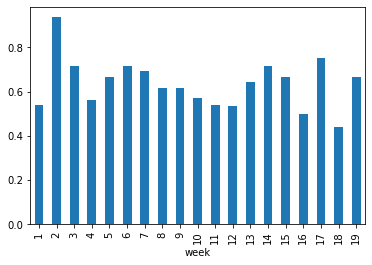

In [83]:
# Week by week predictive accuracy

test_with_preds.groupby(by=['week']).mean()['prediction_correct'].plot.bar()

In [84]:
# On average, how confident is the model in correct vs incorrect picks?

test_with_preds['pick_confidence'] = test_with_preds.apply(lambda x: x.home_win_prob if x.home_win_pred==1 else x.away_win_prob, axis=1)
test_with_preds.groupby(by=['prediction_correct']).mean()[['pick_confidence', 'home_win_pred']]

,pick_confidence,home_win_pred
prediction_correct,,
0,0.656267,0.583333
1,0.696000,0.577381


In [85]:
# Look at some correct picks

test_with_preds[test_with_preds.prediction_correct==1].tail(30)

,season,week,home,away,home_score,away_score,total_score,winner,home_win,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away,home_win_pred,away_win_prob,home_win_prob,prediction_correct,pick_confidence
233,2021,3,Denver Broncos,New York Jets,26,0,26,Home,1,2021,3,Denver Broncos,Teddy Bridgewater,35.000000,266.833333,23.666667,-0.894198,0.833333,3.927363,0.113977,3.166667,1.000000,180.210654,19.518993,28.500000,126.666667,0.289490,0.833333,0.666667,0.500000,4.455522,20.333333,106.500000,1.500000,37.000000,275.500000,23.166667,1.166667,-0.940861,2.166667,0.833333,0.666667,0.500000,-1.875717,-1.693135,-2.434150,2021,3,New York Jets,Zach Wilson,35.500000,234.000000,19.500000,-15.700263,1.000000,-8.619194,-13.343787,5.000000,2.500000,106.400811,-5.061839,25.833333,101.666667,-3.097704,0.333333,0.500000,0.166667,3.817044,24.833333,119.666667,1.000000,35.500000,243.166667,23.833333,1.833333,3.240326,2.500000,0.833333,0.333333,0.333333,-2.816488,-0.970541,0.806631,1,0.170373,0.829627,1,0.829627
234,2021,3,Las Vegas Raiders,Miami Dolphins,31,28,59,Home,1,2021,3,Las Vegas Raiders,Derek Carr,40.166667,358.333333,26.500000,7.064277,1.666667,1.572257,10.114327,2.000000,1.000000,191.038011,2.314245,25.666667,100.000000,-2.172389,1.333333,1.166667,0.500000,3.885166,26.833333,132.000000,1.333333,34.500000,284.166667,23.000000,1.666667,1.570146,1.833333,0.500000,0.166667,0.333333,1.680531,-8.678215,1.765352,2021,3,Miami Dolphins,Jacoby Brissett,31.166667,191.166667,17.333333,-4.502316,0.500000,-7.854731,-3.752510,2.000000,0.333333,134.109748,1.245261,24.833333,113.166667,2.054849,1.166667,0.333333,0.333333,4.305587,24.500000,111.833333,1.166667,34.000000,297.666667,22.000000,1.666667,2.458526,2.000000,1.666667,1.000000,1.000000,-4.751985,-3.190068,-0.831302,1,0.261448,0.738552,1,0.738552
235,2021,3,Buffalo Bills,Washington Football Team,43,21,64,Home,1,2021,3,Buffalo Bills,Josh Allen,40.500000,275.66

In [86]:
# Look at some incorrect picks

test_with_preds[test_with_preds.prediction_correct==0].tail(30)

,season,week,home,away,home_score,away_score,total_score,winner,home_win,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away,home_win_pred,away_win_prob,home_win_prob,prediction_correct,pick_confidence
180,2021,7,New York Giants,Carolina Panthers,25,3,28,Home,1,2021,7,New York Giants,Daniel Jones,39.000000,287.000000,24.333333,0.858976,0.833333,-0.946235,1.657920,2.000000,1.000000,148.630740,9.584292,22.833333,91.000000,-2.069981,1.000000,1.500000,0.500000,3.900061,30.166667,137.333333,1.000000,34.333333,275.500000,25.500000,2.333333,6.255295,1.666667,0.500000,0.833333,0.333333,-0.552956,-9.904539,0.020504,2021,7,Carolina Panthers,Sam Darnold,37.500000,262.500000,22.833333,-2.566730,1.166667,-2.020090,-0.699561,3.000000,1.166667,125.861512,-6.045965,27.166667,111.166667,-0.310741,1.333333,1.000000,0.500000,4.220455,23.333333,112.500000,0.833333,32.833333,216.333333,19.833333,1.666667,-2.652280,2.666667,0.666667,0.666667,0.333333,-1.036010,5.872272,1.154451,0,0.676897,0.323103,0,0.676897
181,2021,7,Tennessee Titans,Kansas City Chiefs,27,3,30,Home,1,2021,7,Tennessee Titans,Ryan Tannehill,34.000000,245.833333,21.500000,0.310077,1.000000,0.153149,3.234684,3.333333,0.666667,188.627631,-3.333851,31.833333,165.166667,3.677322,2.000000,1.000000,0.666667,5.229439,24.500000,107.833333,1.166667,36.000000,291.833333,23.500000,2.000000,3.193912,2.166667,0.500000,0.666667,0.166667,0.979389,-4.647067,0.596204,2021,7,Kansas City Chiefs,Patrick Mahomes,40.500000,314.500000,27.833333,10.957050,3.000000,7.678615,13.154213,1.666667,1.333333,255.370178,12.512633,25.166667,125.500000,0.747125,0.833333,1.166667,0.833333,4.801665,25.166667,134.333333,1.500000,34.500000,287.833333,22.666667,1.833333,5.391329,1.166667,1.000000,0.666667,0.333333,0.295348,-8.061821,-3.275939,0,0.730588,0.269412,0,0.730588
182,2021,7,Cleveland Browns,Denver Broncos,17,14,31,Home,1,2021,7,Cleveland Browns,Case Keenum,27.833333,18

In [88]:
# Compare to qb adjusted elo ratings

elo_plus_algo = test_with_preds.merge(nfl_elo, left_on=['season', 'week', 'home', 'away'],
                                     right_on=['season', 'week', 'home_full_name', 'away_full_name'])
elo_plus_algo['elo_home_win'] = elo_plus_algo.apply(lambda x: 1 if x.qbelo_prob1 > x.qbelo_prob2 else 0, axis=1)
elo_plus_algo['elo_confidence'] = elo_plus_algo.apply(lambda x: x.qbelo_prob1 if x.elo_home_win==1 else x.qbelo_prob2, axis=1)
elo_plus_algo['elo_correct'] = elo_plus_algo.apply(lambda x: 1 if x.elo_home_win == x.home_win else 0, axis=1)
elo_plus_algo

,season,week,home_x,away_x,home_score,away_score,total_score,winner,home_win,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away,home_win_pred,away_win_prob,home_win_prob,prediction_correct,pick_confidence,date,home_y,away_y,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,quality,importance,total_rating,home_full_name,away_full_name,elo_home_win,elo_confidence,elo_correct
0,2021,19,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,2021,19,Los Angeles Rams,Matthew Stafford,33.666667,261.666667,23.000000,5.661562,2.333333,0.355647,6.453580,2.333333,1.333333,195.606964,7.922840,25.333333,106.833333,-1.075588,0.500000,0.666667,0.166667,4.181683,25.166667,101.666667,1.000000,34.500000,256.000000,22.666667,0.500000,-1.434939,3.333333,0.833333,1.166667,0.500000,0.805744,1.787573,4.266528,2021,19,Arizona Cardinals,Kyler Murray,39.666667,265.000000,25.666667,-0.417236,1.166667,-0.334867,0.974514,2.166667,0.500000,217.386156,7.045917,25.833333,121.166667,0.435930,1.000000,1.166667,0.166667,4.821080,26.666667,117.000000,0.500000,32.000000,242.666667,21.333333,2.666667,0.261342,2.000000,0.833333,0.833333,0.500000,-0.186626,-6.544012,2.826652,1,0.378659,0.621341,1,0.621341,2022-01-17,LAR,ARI,1615.789160,1516.586992,0.720154,0.279846,1632.341105,1500.035047,1597.459409,1514.940528,Matthew Stafford,Kyler Murray,169.067416,222.204809,-6.342367,8.168433,0.702535,0.297465,277.097615,-42.847876,179.870436,195.699541,1615.165080,1497.234857,76.0,100.0,88.0,Los Angeles Rams,Arizona Cardinals,1,0.702535,1
1,2021,19,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,2021,19,Kansas City Chiefs,Patrick Mahomes,34.833333,273.166667,23.666667,10.269201,2.000000,4.133457,12.048222,1.333333,0.333333,221.877309,-5.32425

In [90]:
# On average, how confident is the elo model in correct vs incorrect picks?

elo_plus_algo.groupby(by=['elo_correct']).mean()[['elo_confidence', 'elo_home_win']]

,elo_confidence,elo_home_win
elo_correct,,
0,0.638991,0.689320
1,0.692274,0.652174


In [114]:
elo_plus_algo_condensed = elo_plus_algo[['season', 'week', 'home_x', 'away_x', 'home_score', 'away_score', 
                                        'total_score', 'winner', 'home_win', 'home_win_pred', 'prediction_correct', 
                                         'pick_confidence', 'home_win_prob', 'away_win_prob', 'qbelo_prob1', 'qbelo_prob2',
                                         'elo_home_win', 'elo_correct', 'elo_confidence'
                                        ]]
elo_plus_algo_condensed

,season,week,home_x,away_x,home_score,away_score,total_score,winner,home_win,home_win_pred,prediction_correct,pick_confidence,home_win_prob,away_win_prob,qbelo_prob1,qbelo_prob2,elo_home_win,elo_correct,elo_confidence
0,2021,19,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,1,1,0.621341,0.621341,0.378659,0.702535,0.297465,1,1,0.702535
1,2021,19,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,1,1,0.774682,0.774682,0.225318,0.858473,0.141527,1,1,0.858473
2,2021,19,Dallas Cowboys,San Francisco 49ers,17,23,40,Away,0,1,0,0.720499,0.720499,0.279501,0.690316,0.309684,1,0,0.690316
3,2021,19,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,46,Home,1,1,1,0.616480,0.616480,0.383520,0.805219,0.194781,1,1,0.805219
4,2021,19,Buffalo Bills,New England Patriots,47,17,64,Home,1,1,1,0.792162,0.792162,0.207838,0.700099,0.299901,1,1,0.700099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021,1,Detroit Lions,San Francisco 49ers,33,41,74,Away,0,0,1,0.719289,0.280711,0.719289,0.343427,0.656573,0,1,0.656573
260,2021,1,Indianapolis Colts,Seattle Seahawks,16,28,44,Away,0,0,1,0.785444,0.214556,0.785444,0.522245,0.477755,1,0,0.522245
261,2021,1,Tennessee Titans,Arizona Cardinals,13,38,51,Away,0,1,0,0.555905,0.555905,0.444095,0.657171,0.342829,1,0,0.657171
262,2021,1,Washington Football Team,Los Angeles Chargers,16,20,36,Away,0,0,1,0.558924,0.441076,0.558924,0.579076,0.420924,1,0,0.579076


In [115]:
# Look at games where elo is correct, algo is wrong

elo_plus_algo_condensed[(elo_plus_algo_condensed.elo_correct == 1) & (elo_plus_algo_condensed.prediction_correct == 0)]

,season,week,home_x,away_x,home_score,away_score,total_score,winner,home_win,home_win_pred,prediction_correct,pick_confidence,home_win_prob,away_win_prob,qbelo_prob1,qbelo_prob2,elo_home_win,elo_correct,elo_confidence
5,2021,19,Cincinnati Bengals,Las Vegas Raiders,26,19,45,Home,1,0,0,0.668069,0.331931,0.668069,0.740618,0.259382,1,1,0.740618
9,2021,18,Atlanta Falcons,New Orleans Saints,20,30,50,Away,0,1,0,0.718530,0.718530,0.281470,0.405590,0.594410,0,1,0.594410
10,2021,18,Baltimore Ravens,Pittsburgh Steelers,13,16,29,Away,0,1,0,0.622404,0.622404,0.377596,0.495194,0.504806,0,1,0.504806
18,2021,18,New York Giants,Washington Football Team,7,22,29,Away,0,1,0,0.691887,0.691887,0.308113,0.427648,0.572352,0,1,0.572352
20,2021,18,Philadelphia Eagles,Dallas Cowboys,26,51,77,Away,0,1,0,0.540037,0.540037,0.459963,0.481108,0.518892,0,1,0.518892
36,2021,17,Tennessee Titans,Miami Dolphins,34,3,37,Home,1,0,0,0.569452,0.430548,0.569452,0.548288,0.451712,1,1,0.548288
40,2021,16,Las Vegas Raiders,Denver Broncos,17,13,30,Home,1,0,0,0.694135,0.305865,0.694135,0.528301,0.471699,1,1,0.528301
42,2021,16,Atlanta Falcons,Detroit Lions,20,16,36,Home,1,0,0,0.575548,0.424452,0.575548,0.829159,0.170841,1,1,0.829159
46,2021,16,Minnesota Vikings,Los Angeles Rams,23,30,53,Away,0,1,0,0.651376,0.651376,0.348624,0.460543,0.539457,0,1,0.539457
51,2021,16,Tennessee Titans,San Francisco 49ers,20,17,37,Home,1,0,0,0.559567,0.440433,0.559567,0.528548,0.471452,1,1,0.528548


In [116]:
# Look at games where algo is correct, elo is wrong

elo_plus_algo_condensed[(elo_plus_algo_condensed.elo_correct == 0) & (elo_plus_algo_condensed.prediction_correct == 1)]

,season,week,home_x,away_x,home_score,away_score,total_score,winner,home_win,home_win_pred,prediction_correct,pick_confidence,home_win_prob,away_win_prob,qbelo_prob1,qbelo_prob2,elo_home_win,elo_correct,elo_confidence
16,2021,18,Miami Dolphins,New England Patriots,33,24,57,Home,1,1,1,0.624146,0.624146,0.375854,0.479691,0.520309,0,0,0.520309
49,2021,16,Arizona Cardinals,Indianapolis Colts,16,22,38,Away,0,0,1,0.550134,0.449866,0.550134,0.505582,0.494418,1,0,0.505582
64,2021,15,Pittsburgh Steelers,Tennessee Titans,19,13,32,Home,1,1,1,0.674016,0.674016,0.325984,0.447739,0.552261,0,0,0.552261
69,2021,14,Cincinnati Bengals,San Francisco 49ers,23,26,49,Away,0,0,1,0.788773,0.211227,0.788773,0.537964,0.462036,1,0,0.537964
89,2021,13,Cincinnati Bengals,Los Angeles Chargers,22,41,63,Away,0,0,1,0.528423,0.471577,0.528423,0.603671,0.396329,1,0,0.603671
102,2021,12,Indianapolis Colts,Tampa Bay Buccaneers,31,38,69,Away,0,0,1,0.548424,0.451576,0.548424,0.537145,0.462855,1,0,0.537145
118,2021,11,Minnesota Vikings,Green Bay Packers,34,31,65,Home,1,1,1,0.605946,0.605946,0.394054,0.412300,0.587700,0,0,0.587700
123,2021,10,San Francisco 49ers,Los Angeles Rams,31,10,41,Home,1,1,1,0.522782,0.522782,0.477218,0.399543,0.600457,0,0,0.600457
128,2021,10,Los Angeles Chargers,Minnesota Vikings,20,27,47,Away,0,0,1,0.524173,0.475827,0.524173,0.689329,0.310671,1,0,0.689329
138,2021,9,Los Angeles Rams,Tennessee Titans,16,28,44,Away,0,0,1,0.583322,0.416678,0.583322,0.684634,0.315366,1,0,0.684634


In [117]:
elo_plus_algo_condensed

,season,week,home_x,away_x,home_score,away_score,total_score,winner,home_win,home_win_pred,prediction_correct,pick_confidence,home_win_prob,away_win_prob,qbelo_prob1,qbelo_prob2,elo_home_win,elo_correct,elo_confidence
0,2021,19,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,1,1,0.621341,0.621341,0.378659,0.702535,0.297465,1,1,0.702535
1,2021,19,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,1,1,0.774682,0.774682,0.225318,0.858473,0.141527,1,1,0.858473
2,2021,19,Dallas Cowboys,San Francisco 49ers,17,23,40,Away,0,1,0,0.720499,0.720499,0.279501,0.690316,0.309684,1,0,0.690316
3,2021,19,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,46,Home,1,1,1,0.616480,0.616480,0.383520,0.805219,0.194781,1,1,0.805219
4,2021,19,Buffalo Bills,New England Patriots,47,17,64,Home,1,1,1,0.792162,0.792162,0.207838,0.700099,0.299901,1,1,0.700099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021,1,Detroit Lions,San Francisco 49ers,33,41,74,Away,0,0,1,0.719289,0.280711,0.719289,0.343427,0.656573,0,1,0.656573
260,2021,1,Indianapolis Colts,Seattle Seahawks,16,28,44,Away,0,0,1,0.785444,0.214556,0.785444,0.522245,0.477755,1,0,0.522245
261,2021,1,Tennessee Titans,Arizona Cardinals,13,38,51,Away,0,1,0,0.555905,0.555905,0.444095,0.657171,0.342829,1,0,0.657171
262,2021,1,Washington Football Team,Los Angeles Chargers,16,20,36,Away,0,0,1,0.558924,0.441076,0.558924,0.579076,0.420924,1,0,0.579076


In [118]:
elo_plus_algo_condensed.to_csv('../data/games_with_preds.csv')

### Part 2: Regression algorithm for point spreads and over/unders

In [119]:
final_train_df

,season,week,home,away,home_score,away_score,total_score,winner,home_win,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away
277,2020,21,Tampa Bay Buccaneers,Kansas City Chiefs,31,9,40,Home,1,2020,21,Tampa Bay Buccaneers,Tom Brady,39.333333,356.666667,24.666667,15.923216,3.166667,0.982465,16.632192,1.833333,0.666667,213.475887,20.270547,23.666667,101.500000,-0.211070,1.166667,0.833333,0.166667,4.245610,19.666667,82.333333,0.500000,42.166667,269.166667,27.166667,1.833333,-1.009008,2.500000,1.000000,1.000000,0.666667,-2.148367,5.028262,1.415606,2020,21,Kansas City Chiefs,Patrick Mahomes,40.333333,315.166667,25.833333,6.651711,2.000000,0.212780,8.366219,1.666667,1.000000,291.989757,20.421267,23.666667,114.666667,1.868172,1.000000,1.333333,0.333333,4.805043,22.500000,101.500000,0.833333,39.333333,274.166667,23.833333,2.166667,-1.505400,2.833333,0.666667,0.666667,0.166667,-1.252061,-1.634399,-2.205812
278,2020,20,Kansas City Chiefs,Buffalo Bills,38,24,62,Home,1,2020,20,Kansas City Chiefs,Patrick Mahomes,42.333333,338.000000,27.166667,6.484527,2.000000,1.734199,8.489959,1.833333,1.000000,295.612778,23.156688,23.666667,117.500000,1.598599,0.666667,1.333333,0.333333,4.939964,25.000000,109.833333,0.833333,36.000000,251.500000,21.666667,2.166667,-2.385497,2.166667,0.666667,0.833333,0.166667,0.848997,-3.607428,-1.057186,2020,20,Buffalo Bills,Josh Allen,38.833333,309.833333,25.833333,11.409205,2.500000,6.321745,13.145296,1.166667,0.500000,263.204139,38.938768,21.666667,106.166667,0.674089,1.166667,1.000000,0.166667,4.724303,25.166667,119.333333,1.000000,39.000000,220.833333,22.166667,1.000000,-9.648431,2.000000,1.000000,1.000000,0.333333,3.732851,9.416376,-1.377551
279,2020,20,Green Bay Packers,Tampa Bay Buccaneers,26,31,57,Away,0,2020,20,Green Bay Packers,Aaron Rodgers,30.500000,249.166667,22.333333,12.027422,2.833333,11.447265,13.262356,1.500000,0.166667,262.846914,30.010552,27.333333,163.0000

In [136]:
# Train Linear Regression model, Test on Validation Set

iteration = 1
model = LinearRegression()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='total_score')
dump(trained_model, '../saved_models/linear_regression_ts{}.joblib'.format(iteration))

Training RMSE: 13.138589791105504
Validation RMSE: 14.508539508935065


['../saved_models/linear_regression_ts1.joblib']

In [137]:
# Add results to train set

train_pred, train_acc = test_model(trained_model, final_train_df, target='total_score')
train_with_preds = final_train_df.copy()
train_with_preds['total_score_pred'] = train_pred

Test RMSE: 13.353085731112035


In [138]:
iteration = 1
model = LinearRegression()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = True)
dump(trained_model, '../saved_models/linear_regression_hs{}.joblib'.format(iteration))

Training RMSE: 9.357973742207163
Validation RMSE: 9.797788452827469


['../saved_models/linear_regression_hs1.joblib']

In [139]:
train_pred, train_acc = test_model(trained_model, final_train_df, target='point_spread', predict_home=True)
train_with_preds['home_score_pred'] = train_pred

Test RMSE: 9.425267145431823


In [140]:
iteration = 1
model = LinearRegression()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = False)
dump(trained_model, '../saved_models/linear_regression_as{}.joblib'.format(iteration))

Training RMSE: 9.146892708942243
Validation RMSE: 10.042255510879322


['../saved_models/linear_regression_as1.joblib']

In [141]:
train_pred, train_acc = test_model(trained_model, final_train_df, target='point_spread', predict_home=False)
train_with_preds['away_score_pred'] = train_pred

Test RMSE: 9.286728364132681


In [146]:
train_with_preds[['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score', 
                  'home_score_pred', 'away_score_pred', 'total_score_pred']].head(50)

,season,week,home,away,home_score,away_score,total_score,home_score_pred,away_score_pred,total_score_pred
277,2020,21,Tampa Bay Buccaneers,Kansas City Chiefs,31,9,40,26.294951,26.706097,53.001048
278,2020,20,Kansas City Chiefs,Buffalo Bills,38,24,62,24.704805,26.235052,50.939857
279,2020,20,Green Bay Packers,Tampa Bay Buccaneers,26,31,57,31.624885,25.098866,56.723751
280,2020,19,New Orleans Saints,Tampa Bay Buccaneers,20,30,50,30.038603,27.126359,57.164962
281,2020,19,Kansas City Chiefs,Cleveland Browns,22,17,39,28.071342,24.598694,52.670036
282,2020,19,Buffalo Bills,Baltimore Ravens,17,3,20,22.753173,23.215299,45.968472
283,2020,19,Green Bay Packers,Los Angeles Rams,32,18,50,30.309703,21.313034,51.622738
284,2020,18,Pittsburgh Steelers,Cleveland Browns,37,48,85,23.442484,25.431511,48.873995
285,2020,18,New Orleans Saints,Chicago Bears,21,9,30,31.992109,24.527748,56.519857
286,2020,18,Tennessee Titans,Baltimore Ravens,13,20,33,18.866080,24.983251,43.849331


In [147]:
# Train ElasticNet model, Test on Validation Set

iteration = 1
model = ElasticNet()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='total_score')
dump(trained_model, '../saved_models/elasticnet_ts{}.joblib'.format(iteration))

Training RMSE: 13.341688231856356
Validation RMSE: 14.457340497547186


['../saved_models/elasticnet_ts1.joblib']

In [148]:
# Add results to train set

train_pred, train_acc = test_model(trained_model, final_train_df, target='total_score')
train_with_preds = final_train_df.copy()
train_with_preds['total_score_pred'] = train_pred

Test RMSE: 13.514941246013235


In [149]:
iteration = 1
model = ElasticNet()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = True)
dump(trained_model, '../saved_models/elasticnet_hs{}.joblib'.format(iteration))

Training RMSE: 9.484155598102399
Validation RMSE: 9.79027427196496


['../saved_models/elasticnet_hs1.joblib']

In [150]:
train_pred, train_acc = test_model(trained_model, final_train_df, target='point_spread', predict_home=True)
train_with_preds['home_score_pred'] = train_pred

Test RMSE: 9.530709057365659


In [151]:
iteration = 1
model = ElasticNet()
trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = False)
dump(trained_model, '../saved_models/elasticnet_as{}.joblib'.format(iteration))

Training RMSE: 9.313711514122895
Validation RMSE: 9.882447957209475


['../saved_models/elasticnet_as1.joblib']

In [152]:
train_pred, train_acc = test_model(trained_model, final_train_df, target='point_spread', predict_home=False)
train_with_preds['away_score_pred'] = train_pred

Test RMSE: 9.401232200272277


In [153]:
train_with_preds[['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score', 
                  'home_score_pred', 'away_score_pred', 'total_score_pred']].head(50)

,season,week,home,away,home_score,away_score,total_score,home_score_pred,away_score_pred,total_score_pred
277,2020,21,Tampa Bay Buccaneers,Kansas City Chiefs,31,9,40,25.655081,26.369956,52.407131
278,2020,20,Kansas City Chiefs,Buffalo Bills,38,24,62,27.640033,26.621342,54.603840
279,2020,20,Green Bay Packers,Tampa Bay Buccaneers,26,31,57,30.355876,23.608479,54.023464
280,2020,19,New Orleans Saints,Tampa Bay Buccaneers,20,30,50,29.921548,24.506330,54.869842
281,2020,19,Kansas City Chiefs,Cleveland Browns,22,17,39,31.140582,23.940380,54.745065
282,2020,19,Buffalo Bills,Baltimore Ravens,17,3,20,23.385675,25.693926,48.869691
283,2020,19,Green Bay Packers,Los Angeles Rams,32,18,50,28.280553,20.836146,49.028369
284,2020,18,Pittsburgh Steelers,Cleveland Browns,37,48,85,24.384773,22.212480,46.937826
285,2020,18,New Orleans Saints,Chicago Bears,21,9,30,29.361704,21.040400,50.563231
286,2020,18,Tennessee Titans,Baltimore Ravens,13,20,33,20.660669,27.250768,48.065047


In [196]:
# Train Random Forest model, Test on Validation Set

best_rmse = 100000
best_depth = 0
best_estimators = 0

iteration = 1

for depth in range(1, 17):
    for estimators in (50, 100, 150, 200, 300, 400, 500, 1000, 2000, 2500):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = RandomForestRegressor(max_depth=depth, n_estimators = estimators, random_state=19, max_features='sqrt')
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='total_score')
        
        if val_acc <= 14.6:
            dump(trained_model, '../saved_models/rf_reg_ts_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = val_acc
            
        print()
        
print('Best RMSE: {}'.format(best_rmse))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

Depth: 1, Estimators: 50
Training RMSE: 13.57492222981737
Validation RMSE: 15.07537781519747

Depth: 1, Estimators: 100
Training RMSE: 13.592411291567634
Validation RMSE: 15.105150567108641

Depth: 1, Estimators: 150
Training RMSE: 13.59404561357981
Validation RMSE: 15.098285667402985

Depth: 1, Estimators: 200
Training RMSE: 13.595050388528671
Validation RMSE: 15.095583566279311

Depth: 1, Estimators: 300
Training RMSE: 13.596383777798257
Validation RMSE: 15.091964992535853

Depth: 1, Estimators: 400
Training RMSE: 13.597107048339478
Validation RMSE: 15.087734358689538

Depth: 1, Estimators: 500
Training RMSE: 13.596320108328136
Validation RMSE: 15.0891325067203

Depth: 1, Estimators: 1000
Training RMSE: 13.598264575968804
Validation RMSE: 15.094580676040604

Depth: 1, Estimators: 2000
Training RMSE: 13.594773920948963
Validation RMSE: 15.09435190098424

Depth: 1, Estimators: 2500
Training RMSE: 13.594321725158418
Validation RMSE: 15.09130259724553

Depth: 2, Estimators: 50
Training R

Training RMSE: 9.142214898591172
Validation RMSE: 14.609549548014693

Depth: 9, Estimators: 500
Training RMSE: 9.143687799722596
Validation RMSE: 14.597375318253295

Depth: 9, Estimators: 1000
Training RMSE: 9.146522565084226
Validation RMSE: 14.63179523488433

Depth: 9, Estimators: 2000
Training RMSE: 9.151176182624209
Validation RMSE: 14.613497629777273

Depth: 9, Estimators: 2500
Training RMSE: 9.152531246244918
Validation RMSE: 14.6076114169045

Depth: 10, Estimators: 50
Training RMSE: 8.456116791740484
Validation RMSE: 14.581596020286593

Depth: 10, Estimators: 100
Training RMSE: 8.48250295094821
Validation RMSE: 14.520899325346626

Depth: 10, Estimators: 150
Training RMSE: 8.493023850652065
Validation RMSE: 14.526266815520941

Depth: 10, Estimators: 200
Training RMSE: 8.468651890291081
Validation RMSE: 14.565182459759276

Depth: 10, Estimators: 300
Training RMSE: 8.421066442203841
Validation RMSE: 14.558309956884274

Depth: 10, Estimators: 400
Training RMSE: 8.410693392005827
Val

In [198]:
# Add results to train set

best_model = load('../saved_models/rf_reg_ts_iter_1_depth_7_estimators_200.joblib')
train_pred, train_acc = test_model(best_model, final_train_df, target='total_score')
train_with_preds = final_train_df.copy()
train_with_preds['total_score_pred'] = train_pred

Test RMSE: 11.3721615816307


In [199]:
test_model_deconstructed(best_model, train_x, train_y, test_type_regression = 'Training', target='total_score')
test_model_deconstructed(best_model, val_x, val_y, test_type_regression = 'Validation', target='total_score')

Training RMSE: 10.728749304378287
Validation RMSE: 14.487512606008872


14.487512606008872

In [200]:
best_rmse = 100000
best_depth = 0
best_estimators = 0

iteration = 1

for depth in range(1, 17):
    for estimators in (50, 100, 150, 200, 300, 400, 500, 1000, 2000, 2500):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = RandomForestRegressor(max_depth=depth, n_estimators = estimators, random_state=19, max_features='sqrt')
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = True)
        
        if val_acc <= 9.8:
            dump(trained_model, '../saved_models/rf_reg_hs_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = val_acc
            
        print()
        
print('Best RMSE: {}'.format(best_rmse))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

Depth: 1, Estimators: 50
Training RMSE: 9.856837113720085
Validation RMSE: 10.524473832787951

Depth: 1, Estimators: 100
Training RMSE: 9.864517207927769
Validation RMSE: 10.546709532127668

Depth: 1, Estimators: 150
Training RMSE: 9.856672897076304
Validation RMSE: 10.539723797487445

Depth: 1, Estimators: 200
Training RMSE: 9.853082976236506
Validation RMSE: 10.543371584951696

Depth: 1, Estimators: 300
Training RMSE: 9.855042429893533
Validation RMSE: 10.542710718828054

Depth: 1, Estimators: 400
Training RMSE: 9.85339155889697
Validation RMSE: 10.54032953833219

Depth: 1, Estimators: 500
Training RMSE: 9.85237138964969
Validation RMSE: 10.539242790878351

Depth: 1, Estimators: 1000
Training RMSE: 9.853145024302922
Validation RMSE: 10.541435797238245

Depth: 1, Estimators: 2000
Training RMSE: 9.852027206628646
Validation RMSE: 10.539168051048296

Depth: 1, Estimators: 2500
Training RMSE: 9.851438059502952
Validation RMSE: 10.536528569886634

Depth: 2, Estimators: 50
Training RMSE: 9

Training RMSE: 6.505861416861768
Validation RMSE: 9.87328584934689

Depth: 9, Estimators: 1000
Training RMSE: 6.4741518261277555
Validation RMSE: 9.888196642732975

Depth: 9, Estimators: 2000
Training RMSE: 6.4661590938760565
Validation RMSE: 9.899227302320707

Depth: 9, Estimators: 2500
Training RMSE: 6.46405116920658
Validation RMSE: 9.896797385770746

Depth: 10, Estimators: 50
Training RMSE: 5.909889227882135
Validation RMSE: 10.11578582794814

Depth: 10, Estimators: 100
Training RMSE: 5.928019191585303
Validation RMSE: 10.033817068143222

Depth: 10, Estimators: 150
Training RMSE: 5.934747905884154
Validation RMSE: 9.960678923276816

Depth: 10, Estimators: 200
Training RMSE: 5.92040204036769
Validation RMSE: 9.954986300910532

Depth: 10, Estimators: 300
Training RMSE: 5.914894479707639
Validation RMSE: 9.931191365492767

Depth: 10, Estimators: 400
Training RMSE: 5.933735670271432
Validation RMSE: 9.919182072213284

Depth: 10, Estimators: 500
Training RMSE: 5.934497715704648
Validati

In [201]:
best_model = load('../saved_models/rf_reg_hs_iter_1_depth_15_estimators_150.joblib')
train_pred, train_acc = test_model(best_model, final_train_df, target='point_spread', predict_home=True)
train_with_preds['home_score_pred'] = train_pred

Test RMSE: 5.383065086997057


In [202]:
test_model_deconstructed(best_model, train_x, train_y, test_type_regression = 'Training', target='point_spread', predict_home=True)
test_model_deconstructed(best_model, val_x, val_y, test_type_regression = 'Validation', target='point_spread', predict_home=True)

Training RMSE: 4.157159100882218
Validation RMSE: 9.75892420499279


9.75892420499279

In [210]:
best_rmse = 100000
best_depth = 0
best_estimators = 0

iteration = 1

for depth in range(1, 17):
    for estimators in (50, 100, 150, 200, 300, 400, 500, 1000, 2000, 2500):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = RandomForestRegressor(max_depth=depth, n_estimators = estimators, random_state=19, max_features='sqrt')
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = False)
        
        if val_acc <= 10:
            dump(trained_model, '../saved_models/rf_reg_as_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = val_acc
            
        print()
        
print('Best RMSE: {}'.format(best_rmse))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

Depth: 1, Estimators: 50
Training RMSE: 9.521638478597731
Validation RMSE: 10.238619607597574

Depth: 1, Estimators: 100
Training RMSE: 9.52811306335832
Validation RMSE: 10.24830140140401

Depth: 1, Estimators: 150
Training RMSE: 9.531928520644303
Validation RMSE: 10.254267698334317

Depth: 1, Estimators: 200
Training RMSE: 9.533857632155865
Validation RMSE: 10.262860332476297

Depth: 1, Estimators: 300
Training RMSE: 9.534877329844178
Validation RMSE: 10.261997231224052

Depth: 1, Estimators: 400
Training RMSE: 9.534584714941177
Validation RMSE: 10.259239949196648

Depth: 1, Estimators: 500
Training RMSE: 9.535824747506215
Validation RMSE: 10.263035610879564

Depth: 1, Estimators: 1000
Training RMSE: 9.538101747763568
Validation RMSE: 10.263078029854794

Depth: 1, Estimators: 2000
Training RMSE: 9.536638672616217
Validation RMSE: 10.262756432733516

Depth: 1, Estimators: 2500
Training RMSE: 9.536742198953839
Validation RMSE: 10.263725481072116

Depth: 2, Estimators: 50
Training RMSE: 

Training RMSE: 6.522532867085449
Validation RMSE: 10.021903443436113

Depth: 9, Estimators: 1000
Training RMSE: 6.521407296207113
Validation RMSE: 10.009613827406715

Depth: 9, Estimators: 2000
Training RMSE: 6.528335713903596
Validation RMSE: 10.024239422971933

Depth: 9, Estimators: 2500
Training RMSE: 6.535030271218376
Validation RMSE: 10.026045820366452

Depth: 10, Estimators: 50
Training RMSE: 6.061097987631548
Validation RMSE: 10.052147650452085

Depth: 10, Estimators: 100
Training RMSE: 5.983786449796397
Validation RMSE: 10.056276410680207

Depth: 10, Estimators: 150
Training RMSE: 5.957973183948834
Validation RMSE: 10.025729065037611

Depth: 10, Estimators: 200
Training RMSE: 6.007847669615012
Validation RMSE: 10.009944782038515

Depth: 10, Estimators: 300
Training RMSE: 5.973725081508241
Validation RMSE: 9.999569446481175

Depth: 10, Estimators: 400
Training RMSE: 5.97501056927491
Validation RMSE: 10.004344343940662

Depth: 10, Estimators: 500
Training RMSE: 5.9924632125324875

In [211]:
best_model = load('../saved_models/rf_reg_as_iter_1_depth_16_estimators_2500.joblib')
train_pred, train_acc = test_model(trained_model, final_train_df, target='point_spread', predict_home=False)
train_with_preds['away_score_pred'] = train_pred

Test RMSE: 5.315598909717414


In [212]:
test_model_deconstructed(best_model, train_x, train_y, test_type_regression = 'Training', target='point_spread', predict_home=False)
test_model_deconstructed(best_model, val_x, val_y, test_type_regression = 'Validation', target='point_spread', predict_home=False)

Training RMSE: 3.9630830160951245
Validation RMSE: 9.967641973432412


9.967641973432412

In [213]:
train_with_preds[['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score', 
                  'home_score_pred', 'away_score_pred', 'total_score_pred']].head(50)

,season,week,home,away,home_score,away_score,total_score,home_score_pred,away_score_pred,total_score_pred
277,2020,21,Tampa Bay Buccaneers,Kansas City Chiefs,31,9,40,28.981856,15.046029,48.655330
278,2020,20,Kansas City Chiefs,Buffalo Bills,38,24,62,34.280669,25.012154,54.910541
279,2020,20,Green Bay Packers,Tampa Bay Buccaneers,26,31,57,28.156036,29.362505,54.914364
280,2020,19,New Orleans Saints,Tampa Bay Buccaneers,20,30,50,26.036922,29.021671,53.462093
281,2020,19,Kansas City Chiefs,Cleveland Browns,22,17,39,24.625013,20.067154,50.920194
282,2020,19,Buffalo Bills,Baltimore Ravens,17,3,20,21.665875,11.337519,40.469271
283,2020,19,Green Bay Packers,Los Angeles Rams,32,18,50,31.201878,18.666291,48.557575
284,2020,18,Pittsburgh Steelers,Cleveland Browns,37,48,85,31.811221,38.365365,62.641437
285,2020,18,New Orleans Saints,Chicago Bears,21,9,30,23.908819,14.199158,47.086035
286,2020,18,Tennessee Titans,Baltimore Ravens,13,20,33,17.026301,22.748985,45.068527


In [217]:
# Train XBGoost Regressor model, Test on Validation Set

best_rmse = 100000
best_depth = 0
best_estimators = 0

iteration = 1

for depth in range(1, 12):
    for estimators in (25, 50, 75, 100, 125, 150, 200, 250, 300, 500):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = xgb.XGBClassifier(max_depth=depth, n_estimators = estimators, random_state=19, eta=.05,
                                 reg_alpha=1, reg_lambda=1, subsample=.5)
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='total_score')
        
        if val_acc <= 14.6:
            dump(trained_model, '../saved_models/xgb_reg_ts_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = val_acc
            
        print()
        
print('Best RMSE: {}'.format(best_rmse))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

Depth: 1, Estimators: 25
[15:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training RMSE: 15.32951270365577
Validation RMSE: 16.38266263404666

Depth: 1, Estimators: 50
[15:42:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training RMSE: 14.827215137200655
Validation RMSE: 16.8536532353204

Depth: 1, Estimators: 75
[15:42:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used w

Training RMSE: 12.533900339404363
Validation RMSE: 16.573949966453206

Depth: 3, Estimators: 50
[15:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training RMSE: 10.723586247772841
Validation RMSE: 16.773712005655433

Depth: 3, Estimators: 75
[15:46:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training RMSE: 9.710542254296781
Validation RMSE: 16.559490633410885

Depth: 3, Estimators: 100
[15:47:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learn

KeyboardInterrupt: 

In [ ]:
# Add results to train set

best_model = load('../saved_models/xgb_reg_ts_iter_1_depth_7_estimators_200.joblib')
train_pred, train_acc = test_model(best_model, final_train_df, target='total_score')
train_with_preds = final_train_df.copy()
train_with_preds['total_score_pred'] = train_pred

In [ ]:
test_model_deconstructed(best_model, train_x, train_y, test_type_regression = 'Training', target='total_score')
test_model_deconstructed(best_model, val_x, val_y, test_type_regression = 'Validation', target='total_score')

In [ ]:
best_rmse = 100000
best_depth = 0
best_estimators = 0

iteration = 1

for depth in range(1, 7):
    for estimators in (25, 50, 75, 100, 125, 150, 200, 250, 300):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = xgb.XGBRegressor(max_depth=depth, n_estimators = estimators, random_state=19, eta=.05,
                                 reg_alpha=1, reg_lambda=1, subsample=.5)
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = True)
        
        if val_acc <= 9.8:
            dump(trained_model, '../saved_models/xgb_reg_hs_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = val_acc
            
        print()
        
print('Best RMSE: {}'.format(best_rmse))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

In [ ]:
best_model = load('../saved_models/xgb_reg_hs_iter_1_depth_15_estimators_150.joblib')
train_pred, train_acc = test_model(best_model, final_train_df, target='point_spread', predict_home=True)
train_with_preds['home_score_pred'] = train_pred

In [ ]:
test_model_deconstructed(best_model, train_x, train_y, test_type_regression = 'Training', target='point_spread', predict_home=True)
test_model_deconstructed(best_model, val_x, val_y, test_type_regression = 'Validation', target='point_spread', predict_home=True)

In [ ]:
best_rmse = 100000
best_depth = 0
best_estimators = 0

iteration = 1

for depth in range(1, 7):
    for estimators in (25, 50, 75, 100, 125, 150, 200, 250, 300):
        print('Depth: {}, Estimators: {}'.format(depth, estimators))
        model = xgb.XGBRegressor(max_depth=depth, n_estimators = estimators, random_state=19, eta=.05,
                                 reg_alpha=1, reg_lambda=1, subsample=.5)
        trained_model, train_acc, val_acc, train_x, val_x, train_y, val_y = train_model(model, final_train_df, target='point_spread', predict_home = False)
        
        if val_acc <= 10:
            dump(trained_model, '../saved_models/xgb_reg_as_iter_{}_depth_{}_estimators_{}.joblib'.format(iteration, depth, estimators))
            
        if val_acc < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = val_acc
            
        print()
        
print('Best RMSE: {}'.format(best_rmse))
print('Best Depth: {}'.format(best_depth))
print('Best Estimators: {}'.format(best_estimators))

In [ ]:
best_model = load('../saved_models/rf_reg_as_iter_1_depth_16_estimators_2500.joblib')
train_pred, train_acc = test_model(trained_model, final_train_df, target='point_spread', predict_home=False)
train_with_preds['away_score_pred'] = train_pred

In [ ]:
test_model_deconstructed(best_model, train_x, train_y, test_type_regression = 'Training', target='point_spread', predict_home=False)
test_model_deconstructed(best_model, val_x, val_y, test_type_regression = 'Validation', target='point_spread', predict_home=False)

In [ ]:
train_with_preds[['season', 'week', 'home', 'away', 'home_score', 'away_score', 'total_score', 
                  'home_score_pred', 'away_score_pred', 'total_score_pred']].head(50)